In [2]:
import math
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

def qsnr(orig, quant):
    """Calculate the QSNR between two tensors
    """
    qerr = orig - quant
    sum_err = np.sum(qerr * qerr)
    sum_orig = np.sum(orig * orig)
    if sum_err > 0:
        if sum_orig < sum_err:
            if sum_orig == 0:
                return -math.inf
            else:
                # Means error is larger than signal
                return -int(round(10 * math.log10(sum_err/sum_orig), 0))
        # Error portion of signal
        return int(round(10 * math.log10(sum_orig/sum_err), 0))
    # Means no error
    return math.inf

def mse(orig, quant, Size):
    mse = 0
    for i in range(Size):
        mse += (orig.real[i] - quant.real[i]) ** 2
        mse += (orig.imag[i] - quant.imag[i]) ** 2
    return mse
    

In [3]:
data, samplerate = sf.read("samples/yes.wav")
n_fft = 512
int_n_fft = n_fft // 2
frame_size = 512
frame_step = 160
Q_in = 15
Q_fft = 15 - (int(np.log2(int_n_fft)) - 1)
Q_ifft = Q_fft - (int(np.log2(int_n_fft)) - 1) + int(np.log2(n_fft))

frame_idx= 0
frame = data[frame_idx*frame_step:frame_idx*frame_step+frame_size]
win_frame = frame * np.hamming(frame_size)
out_rfft_np = np.fft.rfft(win_frame)

In [4]:
Shift = 4
out_preemph_c = np.array([
		-1456, -2816, -1776, -1520, -1920, -2416, -2128, -2128, -2096, -1952, -2544, -2368, -2032, -1120, -1616, -2416, -2464, -2640, -1984, -1552, -1488, -1472, -1664, -2480, -2352, -1680, -1616, -1616, -1728, -1760, -1872, -2224, -2016, -2256, -2528, -2000, -2144, -1904, -1504, -1952, -2080, -2336, -2608, -1568, -1824, -2384, -1760, -1648, -1872, -2480, -2848, -2640, -2176, -1984, -2336, -2464, -2592, -2240, -2240, -2576, -2128, -2000, -2064, -1808, -1920, -2736, -2720, -2080, -2064, -1824, -1936, -1984, -1712, -1968, -2032, -1856, -1808, -1760, -1712, -2320, -2000, -1712, -2016, -2064, -2144, -1872, -1936, -1504, -1824, -2672, -2208, -2000, -2176, -1984, -2416, -1936, -1712, -2400, -1648, -1536, -2224, -2672, -2560, -2288, -2640, -1936, -1744, -2448, -2656, -2544, -2032, -2272, -2416, -2160, -1840, -2400, -2912, -1872, -1072, -1456, -3136, -2896, -2064, -2528, -1696, -2272, -3392, -1888, -1024, -2096, -2320, -1888, -1872, -2576, -3520, -2944, -2384, -816, -704, -2272, -1760, -1344, -1648, -832, -1296, -2320, -960, -1840, -2432, -864, -2912, -3904, 800, 880, -3328, -3216, -800, 1376, -2368, -6512, -2144, 1088, -1712, -2272, -544, -2560, -2320, -2064, -4080, -304, 1536, -2480, -5648, -6160, -2576, 1072, 592, -1408, -2128, -2096, -2608, -2000, -1520, -2176, 112, -112, -3152, -2368, -3168, -2960, -464, -400, -880, -1744, -2368, -1888, -2144, -4720, -5584, -1680, 1376, -560, -2096, -352, 160, -1024, -2416, -2624, -1840, -1472, -1744, -2464, -1984, -1712, -2288, -1440, -512, -880, -1504, -2000, -1696, -2080, -2768, -2816, -2928, -1712, -288, -512, -1648, -1056, -288, -576, -1104, -2144, -2208, -1856, -2064, -2320, -1040, 336, -880, -2544, -3440, -2704, -208, -256, -2848, -3712, -1936, -384, -1296, -2032, -1216, -512, -1152, -1984, -1248, -848, -1104, -1776, -1216, -672, -1744, -1104, -512, -1248, -2128, -1728, -784, -1424, -1392, -880, -1360, -1552, -1632, -2080, -1632, -560, -656, -1296, -1584, -1936, -1760, -1680, -1520, -848, -1056, -1680, -1440, -1104, -1760, -2128, -1840, -1344, -752, -1600, -2112, -992, -1472, -2224, -1536, -1184, -1104, -1424, -2064, -1920, -976, -1536, -2336, -1792, -624, -784, -2048, -1552, -1104, -1088, -1360, -2112, -1856, -992, -1552, -2016, -1424, -1760, -1584, -1536, -1376, -1072, -1408, -1744, -1712, -1632, -1760, -1488, -1344, -1472, -2080, -2048, -1792, -1536, -1904, -2160, -2000, -2336, -1568, -1776, -2800, -1888, -816, -1568, -2416, -1808, -1712, -1552, -1408, -2208, -2432, -1872, -1440, -1728, -2272, -2080, -1424, -1504, -2080, -2080, -2096, -1504, -720, -1440, -1664, -1856, -2336, -1520, -1552, -1936, -1904, -1952, -1184, -1760, -2448, -1952, -1584, -1728, -2384, -2064, -992, -1328, -2640, -2096, -992, -688, -688, -1408, -1888, -1568, -1456, -1792, -1904, -1824, -1648, -1696, -1616, -1376, -1824, -1792, -1712, -1744, -1584, -1264, -1664, -1968, -1088, -1728, -1552, -1120, -1648, -1536, -2016, -2160, -1600, -688, -1056, -2272, -1536, -1552, -1504, -832, -1392, -1888, -1984, -1216, -672, -1424, -2000, -1552, -1824, -1952, -1232, -1376, -1648, -1552, -1328, -1360, -2064, -1984, -1696, -2144, -2000, -1664, -1136, -1776, -2048, -1520, -1344, -1072, -1968, -1840, -1248, -912, -912, -1568, -1520, -1376, -1888, -2144, -1296, -1056, -1600, -1904, -1968, -1232, -464, -1056, -2000, -2160, -1440, -1008, -1904, -1264, -512, -1072, -1504, -1920, -1520, -1056, -992, -1168, -1456, -1248, -1392, -1904, -1536, -1248, -1856, -1712, -1168, -1664, -1984, -1664, -1008, -880, -1152, -1264, -1216, -1184, -1616, -1408, -1200, -1344, -1088, -960, ])

input_frame = np.array([
		-91, -176, -111, -95, -120, -151, -133, -133, -131, -122, -159, -148, -127, -70, -101, -151, -154, -165, -124, -97, -93, -92, -104, -155, -147, -105, -101, -101, -108, -110, -117, -139, -126, -141, -158, -125, -134, -119, -94, -122, -130, -146, -163, -98, -114, -149, -110, -103, -117, -155, -178, -165, -136, -124, -146, -154, -162, -140, -140, -161, -133, -125, -129, -113, -120, -171, -170, -130, -129, -114, -121, -124, -107, -123, -127, -116, -113, -110, -107, -145, -125, -107, -126, -129, -134, -117, -121, -94, -114, -167, -138, -125, -136, -124, -151, -121, -107, -150, -103, -96, -139, -167, -160, -143, -165, -121, -109, -153, -166, -159, -127, -142, -151, -135, -115, -150, -182, -117, -67, -91, -196, -181, -129, -158, -106, -142, -212, -118, -64, -131, -145, -118, -117, -161, -220, -184, -149, -51, -44, -142, -110, -84, -103, -52, -81, -145, -60, -115, -152, -54, -182, -244, 50, 55, -208, -201, -50, 86, -148, -407, -134, 68, -107, -142, -34, -160, -145, -129, -255, -19, 96, -155, -353, -385, -161, 67, 37, -88, -133, -131, -163, -125, -95, -136, 7, -7, -197, -148, -198, -185, -29, -25, -55, -109, -148, -118, -134, -295, -349, -105, 86, -35, -131, -22, 10, -64, -151, -164, -115, -92, -109, -154, -124, -107, -143, -90, -32, -55, -94, -125, -106, -130, -173, -176, -183, -107, -18, -32, -103, -66, -18, -36, -69, -134, -138, -116, -129, -145, -65, 21, -55, -159, -215, -169, -13, -16, -178, -232, -121, -24, -81, -127, -76, -32, -72, -124, -78, -53, -69, -111, -76, -42, -109, -69, -32, -78, -133, -108, -49, -89, -87, -55, -85, -97, -102, -130, -102, -35, -41, -81, -99, -121, -110, -105, -95, -53, -66, -105, -90, -69, -110, -133, -115, -84, -47, -100, -132, -62, -92, -139, -96, -74, -69, -89, -129, -120, -61, -96, -146, -112, -39, -49, -128, -97, -69, -68, -85, -132, -116, -62, -97, -126, -89, -110, -99, -96, -86, -67, -88, -109, -107, -102, -110, -93, -84, -92, -130, -128, -112, -96, -119, -135, -125, -146, -98, -111, -175, -118, -51, -98, -151, -113, -107, -97, -88, -138, -152, -117, -90, -108, -142, -130, -89, -94, -130, -130, -131, -94, -45, -90, -104, -116, -146, -95, -97, -121, -119, -122, -74, -110, -153, -122, -99, -108, -149, -129, -62, -83, -165, -131, -62, -43, -43, -88, -118, -98, -91, -112, -119, -114, -103, -106, -101, -86, -114, -112, -107, -109, -99, -79, -104, -123, -68, -108, -97, -70, -103, -96, -126, -135, -100, -43, -66, -142, -96, -97, -94, -52, -87, -118, -124, -76, -42, -89, -125, -97, -114, -122, -77, -86, -103, -97, -83, -85, -129, -124, -106, -134, -125, -104, -71, -111, -128, -95, -84, -67, -123, -115, -78, -57, -57, -98, -95, -86, -118, -134, -81, -66, -100, -119, -123, -77, -29, -66, -125, -135, -90, -63, -119, -79, -32, -67, -94, -120, -95, -66, -62, -73, -91, -78, -87, -119, -96, -78, -116, -107, -73, -104, -124, -104, -63, -55, -72, -79, -76, -74, -101, -88, -75, -84, -68, -60, ])
out_window_c = np.array([
		-116, -225, -142, -122, -155, -195, -173, -174, -172, -162, -212, -199, -173, -96, -140, -212, -219, -238, -181, -144, -140, -140, -161, -244, -235, -171, -167, -170, -185, -192, -208, -251, -232, -265, -302, -244, -267, -241, -194, -257, -280, -321, -365, -224, -266, -354, -267, -255, -295, -399, -468, -442, -372, -346, -415, -447, -479, -422, -430, -504, -425, -407, -428, -382, -413, -600, -607, -473, -478, -430, -465, -485, -426, -498, -524, -486, -482, -477, -472, -651, -570, -496, -594, -618, -652, -579, -608, -480, -591, -879, -738, -678, -749, -693, -857, -696, -625, -888, -619, -585, -859, -1046, -1016, -920, -1076, -800, -730, -1038, -1140, -1106, -895, -1013, -1091, -987, -851, -1124, -1380, -897, -520, -714, -1556, -1453, -1047, -1297, -880, -1192, -1798, -1011, -554, -1147, -1282, -1054, -1056, -1467, -2025, -1710, -1398, -483, -421, -1371, -1072, -826, -1022, -521, -818, -1477, -617, -1192, -1589, -569, -1934, -2615, 540, 599, -2283, -2223, -557, 966, -1675, -4639, -1539, 786, -1246, -1666, -402, -1903, -1736, -1555, -3094, -232, 1180, -1918, -4395, -4823, -2029, 850, 472, -1129, -1716, -1700, -2127, -1640, -1253, -1804, 93, -94, -2654, -2004, -2694, -2530, -398, -345, -763, -1518, -2071, -1659, -1892, -4182, -4968, -1501, 1234, -504, -1895, -319, 146, -936, -2216, -2416, -1700, -1364, -1622, -2298, -1856, -1607, -2154, -1360, -485, -835, -1432, -1909, -1623, -1995, -2661, -2714, -2828, -1657, -279, -498, -1605, -1030, -282, -564, -1083, -2106, -2173, -1829, -2037, -2292, -1029, 333, -873, -2525, -3418, -2689, -207, -255, -2839, -3703, -1932, -383, -1295, -2031, -1215, -512, -1152, -1984, -1248, -848, -1104, -1775, -1215, -671, -1741, -1102, -511, -1244, -2120, -1720, -780, -1415, -1382, -873, -1347, -1536, -1613, -2053, -1608, -551, -645, -1271, -1551, -1893, -1717, -1636, -1477, -823, -1022, -1623, -1388, -1062, -1688, -2036, -1756, -1279, -714, -1515, -1994, -934, -1382, -2081, -1433, -1101, -1023, -1315, -1900, -1761, -892, -1399, -2120, -1620, -562, -703, -1830, -1381, -978, -960, -1195, -1847, -1616, -860, -1339, -1731, -1217, -1497, -1340, -1293, -1153, -893, -1167, -1438, -1404, -1331, -1427, -1200, -1078, -1173, -1648, -1613, -1403, -1195, -1472, -1660, -1527, -1772, -1181, -1329, -2081, -1394, -598, -1142, -1746, -1298, -1220, -1098, -988, -1538, -1681, -1284, -980, -1167, -1522, -1382, -938, -983, -1348, -1336, -1335, -949, -451, -893, -1023, -1130, -1410, -909, -919, -1136, -1106, -1123, -674, -993, -1367, -1079, -867, -936, -1277, -1094, -520, -689, -1355, -1064, -498, -341, -338, -683, -905, -743, -682, -829, -870, -823, -735, -747, -703, -591, -773, -750, -707, -711, -637, -502, -651, -760, -414, -649, -575, -409, -593, -545, -704, -744, -543, -230, -347, -736, -490, -487, -465, -253, -417, -556, -575, -347, -188, -393, -542, -414, -478, -503, -312, -342, -403, -373, -313, -315, -469, -443, -372, -461, -422, -345, -231, -354, -401, -292, -253, -198, -357, -327, -217, -156, -153, -257, -245, -217, -292, -325, -193, -154, -228, -267, -270, -166, -61, -137, -254, -269, -176, -121, -223, -146, -58, -119, -164, -205, -160, -109, -101, -117, -143, -121, -133, -179, -142, -114, -167, -152, -103, -144, -170, -141, -85, -73, -95, -104, -99, -96, -131, -113, -96, -108, -87, -77, ])

out_swapped_fft = np.array([
	-3645-3645j, 1202+1588j, 220+213j, -158-64j, 118-48j, -54+13j, -50+58j, 29+2j, 80-55j, -136-22j, 36-7j, -3+52j, -1-66j, -48+59j, 56+31j, -49-44j, 17-46j, -32+70j, 91-20j, -134-28j, 99+78j, -76-97j, 33+128j, 5-70j, -69-41j, 65+53j, 6+10j, -65-61j, 55+60j, -8-66j, -41+1j, 25+41j, -35-31j, 26+8j, 6-54j, -38+32j, 64+2j, -85+1j, 130+26j, -142-136j, -20+189j, 184-116j, -175-47j, 91+157j, -33-91j, -23+5j, 33-69j, -35+118j, 42-71j, -67-30j, 37+61j, 42-14j, -59-33j, -10+122j, 104-135j, -204+24j, 148+71j, 2-144j, -88+153j, 159-38j, -185-133j, 97+216j, -35-189j, -47+51j, 74+90j, 49-187j, -223+166j, 186+6j, 36-160j, -156+117j, 90+34j, 49-90j, -94-49j, 17+133j, -38-41j, 55-38j, -23-54j, -76+117j, 190-13j, -135-46j, 17+90j, 46-64j, 36-117j, -240+178j, 313-2j, -153-150j, -89+122j, 144-17j, -41-79j, 36+34j, -99+67j, 76-50j, 3+34j, 6-152j, -75+141j, 94+26j, -110-148j, 185+83j, -177-89j, 74+146j, 61-107j, -101-23j, 9+121j, 148-136j, -181+78j, 51+57j, 92-126j, -131+5j, -102+110j, 243-99j, -96-96j, -153+178j, 277+56j, -110-289j, -142+170j, 106+42j, 160-110j, -274-16j, 221+116j, -108-118j, -21+72j, -75-103j, 212+145j, -35-234j, -203+119j, 128+141j, 158-202j, -263+27j, 133+199j, 36-308j, 6+237j, -144-194j, 184+326j, -44-357j, -92+64j, -45+444j, 274-449j, -388-88j, 162+483j, 243-482j, -375+204j, 250-119j, -46+129j, 107-164j, -285+220j, 364+10j, -265-434j, -62+472j, 77+28j, 254-445j, -463+232j, 401+296j, -193-577j, -5+345j, 112-182j, -179+83j, 165+82j, -18-148j, -201+61j, 235+29j, 13-109j, -188+136j, 174-80j, -92+10j, -10-86j, -93+133j, 256-190j, -266+48j, 194+261j, -76-222j, -73-19j, 11+113j, 145-63j, -269-77j, 117+377j, 235-468j, -364+137j, 139+162j, 213-73j, -170-194j, -123+369j, 344-264j, -316+51j, 88+112j, 150-117j, -184-60j, -18+175j, 165-156j, -157-121j, -3+362j, 295-337j, -417-3j, 266+192j, 101-149j, -327-104j, 200+232j, -66-230j, -42+239j, 104-128j, -125-28j, 116+177j, -25-191j, -100+133j, 93-64j, -45+0j, 86-33j, -32-3j, -35+30j, -5+44j, 110-64j, -110+11j, 96+30j, -189-104j, 195+316j, 23-450j, -254+367j, 323-119j, -216-160j, 101+225j, -36-140j, -23+112j, 100-70j, -87-3j, 30+84j, 4-100j, -11+25j, 1-45j, 20+32j, 9+39j, -65-71j, 33+15j, 52+92j, -25-128j, -127+49j, 200+20j, -103-99j, 78+132j, -23-169j, -22+120j, 81-48j, -55+22j, -38-55j, 40+66j, 74-50j, -82+2j, 64+2j, 7+40j, -24-146j, -61+90j, 13+35j, 66-53j, 15-56j, -43+131j, -62-159j, 226+228j, 1615+1221j, ])

out_rfft = np.array([
	-3645+0j, 1408+185j, 221-6j, -110+49j, 36-87j, -19+34j, 8+55j, 19-14j, 9-74j, -79+63j, 17-22j, 31+25j, -40-36j, 13+56j, 47-18j, -46+8j, -20-34j, 23+55j, 35-69j, -82+72j, 93-33j, -95+5j, 104+56j, -45-61j, -61+43j, 63-25j, 17+1j, -65+12j, 35-15j, -3-16j, -17+24j, 15-11j, -35+37j, 35-28j, -44-30j, 20+59j, 26-61j, -57+60j, 109-86j, -165+23j, 130+143j, -16-248j, -122+203j, 186-78j, -118-6j, 40+12j, -52-43j, 49+67j, -3-36j, -22-9j, 2-8j, 29+19j, -31-2j, 47+56j, -31-108j, -63+112j, 108-73j, -85-26j, 40+101j, 33-142j, -111+105j, 173-62j, -195-25j, 21+93j, 169-43j, -209-95j, 82+244j, 72-190j, -115+8j, 55+127j, 32-94j, -103-18j, 35+87j, 78-33j, -143-69j, 110+159j, -11-185j, -93+78j, 91+35j, 73-38j, -136-113j, 36+238j, 89-169j, -122+36j, 69+7j, -6-38j, -25+14j, -60+76j, 110-99j, -116-58j, 104+130j, -35-84j, -12+40j, -60-20j, 87+65j, -74-94j, -22+60j, 126-9j, -104-34j, -8+64j, 78-34j, -85-48j, 49+97j, 13-184j, -133+280j, 221-122j, -220-154j, 94+242j, 44-4j, -9-253j, -162+203j, 187+22j, -127-137j, 31+88j, -11-60j, 121+64j, -184-123j, 103+256j, 98-243j, -200+34j, 126+230j, -16-223j, -42-39j, -33+176j, 96-160j, -73+93j, 3-120j, 16+153j, 66-100j, -132-14j, 78+99j, 64-74j, -108-57j, -9+115j, 101-80j, -46+51j, -2-31j, -49+49j, 90-60j, -121+23j, 74+34j, 56-17j, -84-81j, -35+152j, 121-54j, -85-62j, -22+34j, 97+32j, -60-45j, -36+18j, 32+26j, 3-2j, -56-47j, 55+58j, 10-54j, -57+5j, 33+61j, 35-83j, -87+41j, 82-36j, -30+79j, 24-39j, -41-46j, 14+61j, 6-20j, 23+7j, -28+1j, -2-51j, -36+72j, 93-27j, -58-57j, -67+93j, 158-24j, -136-90j, -15+79j, 102+36j, -40-90j, -73+67j, 107+5j, -33-77j, -64+26j, 86+46j, -37-22j, -27-44j, -8+53j, 34-3j, 3-23j, -53-9j, 51+28j, 16-11j, -48-6j, 23-2j, 0+8j, 4-7j, 12+18j, -26-54j, -17+57j, 23-3j, -33-40j, 21+32j, 23-20j, -55+6j, 32+26j, -8-36j, -22+15j, 34+10j, -2-39j, -31+21j, 20+22j, -14-23j, 10-3j, -6+26j, 5-13j, -45+1j, 45+3j, -21-6j, 18-10j, -17+12j, 3+14j, -7-10j, -8-5j, 8+9j, 1-4j, -8+10j, 17+3j, -10-19j, -4+2j, 8+33j, -4-25j, -2+7j, 0+5j, -6-6j, 12+0j, -18-2j, 11+3j, 3+5j, -7-5j, 1+2j, -2+2j, 0-3j, -1+0j, 1+4j, 0-1j, -2+2j, -3-1j, -2+1j, 1+2j, -2+1j, -2+0j, 0+3j, -1+0j, -2+0j, -2+3j, -1+2j, -1+2j, -1+3j, 2+0j, ])
in_ifft = np.array([
	-1823-1823j, 601+794j, 110+108j, -78-32j, 59-23j, -27+7j, -24+30j, 15+1j, 40-28j, -68-11j, 18-2j, -1+27j, 0-34j, -24+30j, 29+16j, -24-22j, 8-23j, -16+35j, 46-10j, -67-14j, 50+40j, -38-48j, 17+63j, 3-34j, -34-20j, 33+28j, 3+5j, -32-31j, 28+30j, -3-33j, -20+0j, 12+21j, -17-14j, 13+4j, 3-27j, -19+17j, 32+2j, -43+2j, 65+14j, -72-68j, -10+95j, 92-58j, -87-23j, 46+79j, -16-45j, -11+3j, 16-33j, -18+59j, 21-35j, -34-15j, 19+31j, 22-6j, -28-16j, -5+62j, 53-67j, -102+14j, 75+36j, 0-71j, -43+78j, 80-17j, -92-65j, 49+109j, -17-94j, -24+26j, 38+47j, 25-92j, -112+84j, 93+4j, 18-79j, -78+60j, 45+18j, 25-44j, -47-23j, 9+68j, -19-20j, 27-17j, -11-26j, -38+60j, 95-5j, -68-23j, 9+47j, 22-31j, 18-58j, -120+90j, 157+0j, -76-74j, -45+63j, 72-7j, -20-39j, 17+19j, -50+36j, 38-23j, 1+18j, 3-74j, -39+73j, 47+15j, -56-72j, 93+43j, -88-44j, 38+75j, 30-52j, -50-10j, 5+62j, 74-67j, -91+41j, 25+30j, 45-61j, -66+3j, -52+57j, 122-47j, -49-46j, -77+90j, 138+28j, -56-143j, -71+87j, 53+23j, 80-53j, -138-6j, 109+60j, -53-57j, -11+38j, -38-50j, 106+75j, -17-115j, -102+62j, 64+72j, 79-99j, -132+15j, 66+100j, 17-152j, 3+120j, -72-95j, 91+165j, -24-176j, -46+34j, -23+224j, 136-223j, -195-42j, 80+243j, 121-239j, -189+104j, 125-58j, -23+66j, 53-79j, -143+111j, 180+6j, -134-215j, -33+238j, 37+16j, 125-221j, -232+119j, 200+150j, -97-286j, -5+175j, 55-89j, -91+43j, 82+43j, -10-71j, -102+32j, 116+16j, 5-53j, -96+70j, 86-38j, -48+7j, -6-42j, -49+68j, 127-93j, -134+26j, 95+132j, -39-109j, -38-8j, 4+58j, 71-30j, -137-36j, 57+190j, 117-233j, -184+70j, 69+82j, 104-35j, -87-95j, -63+186j, 170-130j, -160+27j, 43+58j, 75-57j, -94-28j, -10+90j, 81-76j, -81-59j, -4+183j, 147-166j, -210+1j, 132+98j, 50-73j, -165-50j, 99+117j, -35-113j, -23+122j, 50-62j, -63-13j, 56+90j, -15-92j, -51+68j, 44-29j, -24+2j, 42-14j, -18+0j, -19+16j, -3+24j, 53-30j, -57+7j, 46+17j, -96-51j, 95+159j, 10-222j, -128+185j, 159-58j, -109-79j, 48+114j, -20-68j, -13+58j, 48-33j, -46+0j, 14+43j, 0-48j, -7+14j, -1-21j, 8+17j, 3+21j, -35-35j, 14+10j, 24+48j, -15-62j, -66+26j, 98+11j, -53-48j, 37+68j, -14-83j, -13+61j, 39-22j, -29+12j, -21-25j, 18+34j, 35-23j, -43+2j, 30+4j, 1+22j, -13-72j, -33+47j, 4+19j, 31-24j, 6-26j, -24+67j, -33-78j, 111+116j, 806+613j, ])

out_swapped_fft = np.array([
	-13+3j, -10+1j, -10-1j, -11-1j, -9-2j, -11-3j, -8+0j, -8-3j, -10-3j, -8-2j, -8-1j, -8-4j, -10-2j, -8-2j, -8-3j, -9-4j, -9-7j, -11-6j, -10-6j, -8-6j, -10-8j, -13-4j, -10-10j, -10-6j, -11-9j, -16-12j, -14-10j, -15-12j, -17-11j, -15-14j, -16-11j, -14-10j, -14-17j, -22-13j, -16-11j, -17-13j, -15-14j, -18-13j, -16-12j, -17-18j, -19-14j, -20-18j, -22-15j, -21-13j, -19-25j, -23-20j, -25-19j, -28-21j, -22-25j, -21-16j, -30-31j, -33-26j, -35-22j, -24-31j, -38-33j, -29-30j, -36-28j, -28-33j, -45-26j, -18-20j, -51-43j, -34-38j, -29-35j, -58-29j, -17-37j, -40-33j, -34-45j, -62-54j, -43-14j, -13-43j, -34-26j, -32-17j, -26-47j, -20-38j, -49-18j, -58-82j, 18+18j, -71-69j, -17+30j, -52-145j, -49+25j, -39-52j, -11-59j, -55-49j, -97-7j, 38-59j, -137-151j, -63+27j, 16-36j, -54-52j, -66-52j, -39-56j, 3-3j, -83-62j, -83-80j, -12-10j, -24-47j, -64-51j, -58-131j, -155-47j, 39-16j, -59-10j, 5-29j, -70-75j, -53-42j, -50-72j, -58-49j, -67-43j, -14-26j, -44-59j, -50-62j, -83-86j, -89-52j, -8-15j, -50-33j, -9-18j, -34-65j, -68-57j, -64-71j, -33+10j, -27-79j, -107-84j, -5-8j, -88-116j, -59-11j, -41-63j, -39-17j, -36-61j, -39-27j, -34-55j, -38-21j, -55-35j, -17-38j, -67-55j, -24-44j, -44-27j, -42-47j, -50-64j, -50-17j, -20-40j, -48-60j, -54-50j, -46-27j, -33-50j, -43-33j, -53-64j, -54-40j, -22-46j, -62-30j, -43-64j, -44-34j, -32-42j, -59-55j, -28-44j, -66-50j, -17-22j, -57-43j, -31-30j, -38-59j, -50-26j, -42-53j, -38-45j, -42-41j, -37-29j, -37-44j, -44-41j, -44-38j, -33-36j, -51-50j, -44-38j, -46-51j, -47-55j, -37-41j, -65-44j, -19-35j, -54-41j, -38-35j, -31-48j, -52-41j, -31-36j, -47-44j, -28-31j, -42-41j, -41-30j, -14-28j, -32-35j, -43-28j, -30-36j, -35-35j, -20-30j, -43-33j, -26-29j, -39-35j, -16-21j, -42-33j, -16-10j, -11-22j, -29-23j, -22-26j, -28-25j, -22-23j, -22-20j, -25-24j, -22-22j, -20-16j, -19-23j, -13-20j, -18-13j, -19-17j, -21-22j, -17-7j, -11-23j, -15-15j, -14-9j, -13-17j, -19-11j, -6-12j, -18-12j, -14-16j, -9-10j, -13-11j, -11-10j, -15-14j, -12-14j, -12-11j, -8-11j, -12-9j, -7-7j, -11-10j, -7-4j, -5-9j, -8-7j, -9-10j, -6-4j, -6-9j, -9-5j, -2-4j, -8-9j, -6-4j, -7-4j, -3-4j, -4-5j, -4-3j, -3-4j, -4-5j, -4-5j, -4-3j, -5-6j, -3-5j, -5-4j, -3-2j, -4-4j, -3-3j, -5-5j, -5-3j, -4-5j, ])

out_irfft = np.array([
	-13, 3, -10, 1, -10, -1, -11, -1, -9, -2, -11, -3, -8, 0, -8, -3, -10, -3, -8, -2, -8, -1, -8, -4, -10, -2, -8, -2, -8, -3, -9, -4, -9, -7, -11, -6, -10, -6, -8, -6, -10, -8, -13, -4, -10, -10, -10, -6, -11, -9, -16, -12, -14, -10, -15, -12, -17, -11, -15, -14, -16, -11, -14, -10, -14, -17, -22, -13, -16, -11, -17, -13, -15, -14, -18, -13, -16, -12, -17, -18, -19, -14, -20, -18, -22, -15, -21, -13, -19, -25, -23, -20, -25, -19, -28, -21, -22, -25, -21, -16, -30, -31, -33, -26, -35, -22, -24, -31, -38, -33, -29, -30, -36, -28, -28, -33, -45, -26, -18, -20, -51, -43, -34, -38, -29, -35, -58, -29, -17, -37, -40, -33, -34, -45, -62, -54, -43, -14, -13, -43, -34, -26, -32, -17, -26, -47, -20, -38, -49, -18, -58, -82, 18, 18, -71, -69, -17, 30, -52, -145, -49, 25, -39, -52, -11, -59, -55, -49, -97, -7, 38, -59, -137, -151, -63, 27, 16, -36, -54, -52, -66, -52, -39, -56, 3, -3, -83, -62, -83, -80, -12, -10, -24, -47, -64, -51, -58, -131, -155, -47, 39, -16, -59, -10, 5, -29, -70, -75, -53, -42, -50, -72, -58, -49, -67, -43, -14, -26, -44, -59, -50, -62, -83, -86, -89, -52, -8, -15, -50, -33, -9, -18, -34, -65, -68, -57, -64, -71, -33, 10, -27, -79, -107, -84, -5, -8, -88, -116, -59, -11, -41, -63, -39, -17, -36, -61, -39, -27, -34, -55, -38, -21, -55, -35, -17, -38, -67, -55, -24, -44, -44, -27, -42, -47, -50, -64, -50, -17, -20, -40, -48, -60, -54, -50, -46, -27, -33, -50, -43, -33, -53, -64, -54, -40, -22, -46, -62, -30, -43, -64, -44, -34, -32, -42, -59, -55, -28, -44, -66, -50, -17, -22, -57, -43, -31, -30, -38, -59, -50, -26, -42, -53, -38, -45, -42, -41, -37, -29, -37, -44, -44, -41, -44, -38, -33, -36, -51, -50, -44, -38, -46, -51, -47, -55, -37, -41, -65, -44, -19, -35, -54, -41, -38, -35, -31, -48, -52, -41, -31, -36, -47, -44, -28, -31, -42, -41, -41, -30, -14, -28, -32, -35, -43, -28, -30, -36, -35, -35, -20, -30, -43, -33, -26, -29, -39, -35, -16, -21, -42, -33, -16, -10, -11, -22, -29, -23, -22, -26, -28, -25, -22, -23, -22, -20, -25, -24, -22, -22, -20, -16, -19, -23, -13, -20, -18, -13, -19, -17, -21, -22, -17, -7, -11, -23, -15, -15, -14, -9, -13, -17, -19, -11, -6, -12, -18, -12, -14, -16, -9, -10, -13, -11, -11, -10, -15, -14, -12, -14, -12, -11, -8, -11, -12, -9, -7, -7, -11, -10, -7, -4, -5, -9, -8, -7, -9, -10, -6, -4, -6, -9, -9, -5, -2, -4, -8, -9, -6, -4, -7, -4, -3, -4, -4, -5, -4, -3, -3, -4, -4, -5, -4, -5, -4, -3, -5, -6, -3, -5, -5, -4, -3, -2, -4, -4, -3, -3, -5, -5, -5, -3, -4, -5, ])
out_iwindow_c = np.array([
		-163, 37, -125, 12, -125, -13, -136, -13, -110, -25, -132, -36, -94, 0, -92, -35, -113, -34, -88, -22, -86, -11, -83, -41, -100, -20, -78, -19, -75, -28, -81, -36, -79, -60, -93, -50, -81, -48, -62, -46, -75, -59, -94, -28, -69, -68, -66, -39, -70, -56, -98, -72, -82, -58, -85, -67, -92, -59, -79, -72, -80, -54, -68, -48, -66, -78, -99, -58, -69, -47, -71, -54, -61, -56, -70, -50, -60, -45, -62, -65, -67, -49, -68, -61, -73, -49, -67, -41, -59, -77, -69, -60, -73, -55, -80, -59, -61, -68, -56, -42, -78, -80, -84, -65, -86, -54, -58, -74, -89, -76, -66, -68, -80, -62, -61, -71, -95, -55, -38, -41, -103, -86, -67, -74, -56, -67, -110, -55, -32, -68, -73, -60, -61, -80, -108, -93, -74, -24, -22, -72, -56, -43, -52, -28, -42, -74, -32, -59, -76, -28, -88, -123, 26, 26, -104, -100, -25, 42, -74, -204, -69, 34, -54, -72, -15, -80, -74, -66, -129, -10, 49, -77, -177, -193, -80, 34, 20, -45, -68, -65, -81, -64, -48, -68, 3, -4, -99, -74, -98, -94, -14, -12, -28, -54, -73, -59, -66, -148, -175, -53, 43, -18, -66, -12, 5, -32, -77, -82, -58, -46, -54, -78, -63, -53, -72, -46, -15, -28, -47, -62, -53, -65, -87, -90, -93, -54, -9, -16, -52, -34, -10, -19, -35, -67, -70, -58, -65, -73, -34, 10, -28, -80, -108, -85, -6, -8, -88, -116, -59, -11, -41, -63, -39, -17, -36, -61, -39, -27, -34, -55, -38, -21, -55, -35, -17, -38, -67, -56, -25, -45, -45, -28, -43, -48, -51, -65, -51, -18, -21, -41, -50, -62, -56, -52, -48, -28, -35, -52, -45, -35, -56, -67, -57, -42, -24, -49, -66, -32, -46, -69, -48, -37, -35, -46, -65, -61, -31, -49, -73, -56, -19, -25, -64, -49, -35, -34, -44, -68, -58, -31, -49, -62, -45, -54, -50, -49, -45, -35, -45, -54, -54, -51, -55, -48, -42, -46, -65, -64, -57, -49, -60, -67, -62, -73, -50, -55, -88, -60, -26, -49, -75, -58, -54, -50, -45, -69, -76, -60, -46, -54, -71, -67, -43, -48, -65, -64, -65, -48, -23, -46, -52, -58, -72, -47, -51, -62, -61, -61, -36, -54, -77, -60, -48, -54, -73, -66, -31, -41, -82, -65, -32, -21, -23, -46, -61, -49, -48, -57, -62, -56, -50, -53, -51, -47, -59, -58, -54, -54, -50, -41, -49, -60, -35, -54, -49, -36, -53, -49, -61, -64, -51, -21, -34, -72, -48, -48, -46, -30, -44, -58, -66, -39, -22, -44, -67, -45, -54, -62, -36, -41, -54, -46, -47, -44, -67, -63, -55, -66, -57, -53, -40, -55, -62, -47, -38, -38, -61, -57, -41, -24, -30, -55, -50, -45, -59, -66, -41, -28, -42, -65, -66, -38, -16, -31, -63, -73, -50, -34, -60, -35, -27, -36, -37, -47, -38, -30, -30, -40, -41, -52, -42, -54, -44, -33, -56, -68, -35, -58, -59, -47, -36, -24, -49, -49, -37, -37, -62, -63, -63, -38, -50, -63, ])


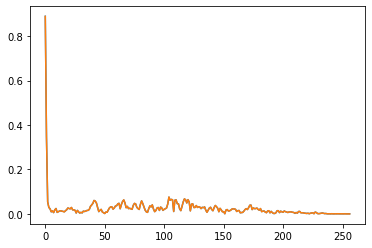

In [5]:
plt.plot(np.abs(out_rfft) * 2**(-Q_fft-Shift))
plt.plot(np.abs(np.fft.rfft(out_window_c*2**(-Q_in-Shift))))

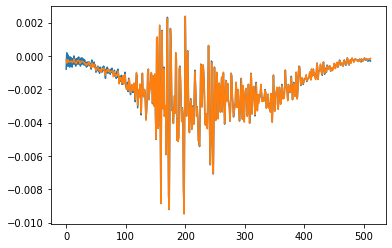

In [6]:
plt.plot(out_irfft * 2**(-Q_ifft-Shift))
plt.plot(out_window_c * 2**(-Q_in-Shift))

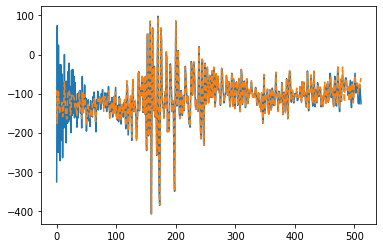

In [7]:
plt.plot(out_iwindow_c*2)
plt.plot(input_frame, '--')

# FLOAT 32

In [8]:
out_window_c = np.array([
		-0.000222, -0.000430, -0.000271, -0.000233, -0.000295, -0.000373, -0.000330, -0.000332, -0.000329, -0.000308, -0.000405, -0.000380, -0.000329, -0.000183, -0.000268, -0.000405, -0.000418, -0.000453, -0.000345, -0.000274, -0.000266, -0.000267, -0.000307, -0.000465, -0.000448, -0.000325, -0.000318, -0.000324, -0.000353, -0.000366, -0.000396, -0.000479, -0.000443, -0.000505, -0.000577, -0.000465, -0.000508, -0.000460, -0.000371, -0.000491, -0.000534, -0.000611, -0.000696, -0.000427, -0.000507, -0.000676, -0.000509, -0.000486, -0.000564, -0.000762, -0.000892, -0.000844, -0.000709, -0.000659, -0.000792, -0.000852, -0.000914, -0.000805, -0.000821, -0.000962, -0.000810, -0.000776, -0.000816, -0.000728, -0.000788, -0.001144, -0.001159, -0.000902, -0.000912, -0.000821, -0.000887, -0.000925, -0.000812, -0.000950, -0.000999, -0.000928, -0.000920, -0.000910, -0.000901, -0.001241, -0.001088, -0.000947, -0.001133, -0.001179, -0.001244, -0.001104, -0.001160, -0.000915, -0.001127, -0.001677, -0.001407, -0.001294, -0.001429, -0.001322, -0.001634, -0.001328, -0.001192, -0.001695, -0.001180, -0.001115, -0.001638, -0.001995, -0.001937, -0.001755, -0.002052, -0.001525, -0.001392, -0.001979, -0.002175, -0.002110, -0.001707, -0.001932, -0.002080, -0.001883, -0.001623, -0.002143, -0.002631, -0.001712, -0.000992, -0.001362, -0.002968, -0.002772, -0.001998, -0.002474, -0.001678, -0.002273, -0.003430, -0.001929, -0.001057, -0.002187, -0.002446, -0.002011, -0.002014, -0.002799, -0.003863, -0.003262, -0.002667, -0.000922, -0.000803, -0.002615, -0.002044, -0.001576, -0.001949, -0.000993, -0.001561, -0.002818, -0.001176, -0.002274, -0.003031, -0.001086, -0.003690, -0.004987, 0.001030, 0.001142, -0.004354, -0.004240, -0.001063, 0.001842, -0.003194, -0.008849, -0.002935, 0.001500, -0.002377, -0.003177, -0.000766, -0.003630, -0.003312, -0.002966, -0.005902, -0.000443, 0.002251, -0.003658, -0.008382, -0.009199, -0.003870, 0.001620, 0.000900, -0.002153, -0.003273, -0.003242, -0.004057, -0.003129, -0.002391, -0.003441, 0.000178, -0.000179, -0.005062, -0.003822, -0.005139, -0.004825, -0.000760, -0.000658, -0.001455, -0.002896, -0.003950, -0.003163, -0.003608, -0.007977, -0.009476, -0.002863, 0.002354, -0.000962, -0.003614, -0.000609, 0.000278, -0.001785, -0.004227, -0.004607, -0.003242, -0.002602, -0.003093, -0.004384, -0.003541, -0.003065, -0.004108, -0.002593, -0.000925, -0.001594, -0.002731, -0.003641, -0.003095, -0.003806, -0.005076, -0.005176, -0.005394, -0.003161, -0.000533, -0.000949, -0.003061, -0.001965, -0.000537, -0.001076, -0.002066, -0.004018, -0.004144, -0.003489, -0.003885, -0.004373, -0.001963, 0.000635, -0.001664, -0.004817, -0.006520, -0.005130, -0.000395, -0.000486, -0.005415, -0.007062, -0.003685, -0.000731, -0.002469, -0.003873, -0.002318, -0.000976, -0.002197, -0.003784, -0.002380, -0.001617, -0.002105, -0.003386, -0.002318, -0.001280, -0.003322, -0.002102, -0.000974, -0.002373, -0.004043, -0.003281, -0.001487, -0.002699, -0.002636, -0.001664, -0.002570, -0.002929, -0.003076, -0.003915, -0.003068, -0.001051, -0.001229, -0.002425, -0.002959, -0.003610, -0.003276, -0.003121, -0.002818, -0.001569, -0.001950, -0.003095, -0.002647, -0.002025, -0.003220, -0.003884, -0.003350, -0.002440, -0.001362, -0.002889, -0.003803, -0.001781, -0.002635, -0.003969, -0.002733, -0.002100, -0.001952, -0.002509, -0.003624, -0.003360, -0.001702, -0.002668, -0.004043, -0.003090, -0.001072, -0.001341, -0.003490, -0.002634, -0.001866, -0.001831, -0.002279, -0.003523, -0.003082, -0.001640, -0.002554, -0.003302, -0.002321, -0.002855, -0.002557, -0.002467, -0.002199, -0.001704, -0.002226, -0.002743, -0.002678, -0.002539, -0.002723, -0.002289, -0.002056, -0.002238, -0.003144, -0.003077, -0.002676, -0.002280, -0.002808, -0.003166, -0.002912, -0.003379, -0.002253, -0.002535, -0.003970, -0.002659, -0.001141, -0.002177, -0.003331, -0.002475, -0.002326, -0.002093, -0.001885, -0.002934, -0.003207, -0.002449, -0.001869, -0.002225, -0.002902, -0.002635, -0.001789, -0.001874, -0.002570, -0.002548, -0.002546, -0.001811, -0.000859, -0.001703, -0.001951, -0.002156, -0.002689, -0.001733, -0.001753, -0.002166, -0.002110, -0.002142, -0.001286, -0.001893, -0.002607, -0.002058, -0.001653, -0.001784, -0.002436, -0.002087, -0.000992, -0.001314, -0.002584, -0.002029, -0.000950, -0.000651, -0.000644, -0.001302, -0.001726, -0.001417, -0.001300, -0.001581, -0.001660, -0.001571, -0.001402, -0.001425, -0.001340, -0.001127, -0.001475, -0.001430, -0.001349, -0.001356, -0.001215, -0.000957, -0.001242, -0.001449, -0.000790, -0.001237, -0.001096, -0.000780, -0.001131, -0.001039, -0.001343, -0.001418, -0.001035, -0.000438, -0.000663, -0.001404, -0.000935, -0.000930, -0.000887, -0.000483, -0.000795, -0.001061, -0.001097, -0.000661, -0.000360, -0.000749, -0.001035, -0.000789, -0.000912, -0.000959, -0.000595, -0.000653, -0.000768, -0.000711, -0.000597, -0.000601, -0.000895, -0.000845, -0.000709, -0.000880, -0.000806, -0.000658, -0.000441, -0.000676, -0.000765, -0.000557, -0.000483, -0.000378, -0.000680, -0.000624, -0.000415, -0.000297, -0.000291, -0.000491, -0.000467, -0.000414, -0.000557, -0.000620, -0.000367, -0.000293, -0.000436, -0.000508, -0.000515, -0.000316, -0.000117, -0.000260, -0.000484, -0.000512, -0.000335, -0.000230, -0.000426, -0.000278, -0.000110, -0.000227, -0.000312, -0.000392, -0.000305, -0.000208, -0.000192, -0.000223, -0.000273, -0.000230, -0.000253, -0.000341, -0.000271, -0.000217, -0.000319, -0.000290, -0.000196, -0.000275, -0.000325, -0.000270, -0.000162, -0.000140, -0.000182, -0.000198, -0.000189, -0.000183, -0.000249, -0.000216, -0.000184, -0.000205, -0.000166, -0.000146, ])

out_swapped_fft = np.array([
	-0.444425-0.444471j, 0.147275+0.194642j, 0.027436+0.026680j, -0.018663-0.007176j, 0.014902-0.005467j, -0.006206+0.001986j, -0.005695+0.007473j, 0.003942+0.000640j, 0.010041-0.006324j, -0.016139-0.002189j, 0.004948-0.000271j, -0.000006+0.006766j, 0.000338-0.007721j, -0.005458+0.007491j, 0.007430+0.004324j, -0.005510-0.004976j, 0.002125-0.005343j, -0.003766+0.008789j, 0.011320-0.002141j, -0.016141-0.003256j, 0.012492+0.009640j, -0.009013-0.011697j, 0.004403+0.015917j, 0.000866-0.008477j, -0.008141-0.004794j, 0.008170+0.006828j, 0.001121+0.001526j, -0.007603-0.007261j, 0.006941+0.007631j, -0.000752-0.007954j, -0.004860+0.000304j, 0.003283+0.005407j, -0.004007-0.003549j, 0.003328+0.001073j, 0.000848-0.006385j, -0.004421+0.004222j, 0.007978+0.000512j, -0.010129+0.000289j, 0.016129+0.003253j, -0.017095-0.016406j, -0.002201+0.023343j, 0.022771-0.013964j, -0.021021-0.005531j, 0.011207+0.019485j, -0.003859-0.010800j, -0.002701+0.000881j, 0.004337-0.008159j, -0.004004+0.014596j, 0.005157-0.008426j, -0.007892-0.003491j, 0.004670+0.007666j, 0.005405-0.001529j, -0.006854-0.003917j, -0.000888+0.015013j, 0.013148-0.016200j, -0.024670+0.003036j, 0.018275+0.008998j, 0.000496-0.017387j, -0.010456+0.018874j, 0.019651-0.004264j, -0.022312-0.015949j, 0.012105+0.026449j, -0.003994-0.022785j, -0.005456+0.006374j, 0.009045+0.010898j, 0.005977-0.022802j, -0.027180+0.020229j, 0.022784+0.000787j, 0.004343-0.019581j, -0.019107+0.014334j, 0.011030+0.004020j, 0.006091-0.010908j, -0.011419-0.006003j, 0.002043+0.016339j, -0.004516-0.005033j, 0.006712-0.004695j, -0.002872-0.006649j, -0.009265+0.014356j, 0.023214-0.001586j, -0.016589-0.005575j, 0.002044+0.011030j, 0.005768-0.007906j, 0.004332-0.014265j, -0.029414+0.021730j, 0.038192-0.000389j, -0.018614-0.018334j, -0.010955+0.014862j, 0.017594-0.002117j, -0.004915-0.009562j, 0.004446+0.004193j, -0.012264+0.008250j, 0.009326-0.006108j, 0.000447+0.004165j, 0.000888-0.018458j, -0.009058+0.017200j, 0.011397+0.003055j, -0.013435-0.018011j, 0.022668+0.010100j, -0.021480-0.010890j, 0.008992+0.017854j, 0.007556-0.013092j, -0.012457-0.002827j, 0.001119+0.014884j, 0.017877-0.016606j, -0.022094+0.009592j, 0.006142+0.006962j, 0.011161-0.015412j, -0.016032+0.000657j, -0.012483+0.013445j, 0.029670-0.012158j, -0.011642-0.011745j, -0.018580+0.021792j, 0.033877+0.006946j, -0.013491-0.035224j, -0.017337+0.020858j, 0.012910+0.005003j, 0.019510-0.013328j, -0.033523-0.001945j, 0.026986+0.014258j, -0.013343-0.014427j, -0.002581+0.008835j, -0.009168-0.012474j, 0.025877+0.017666j, -0.004202-0.028545j, -0.024776+0.014482j, 0.015818+0.017275j, 0.019344-0.024627j, -0.032221+0.003440j, 0.016086+0.024290j, 0.004482-0.037519j, 0.000768+0.028871j, -0.017526-0.023666j, 0.022623+0.039857j, -0.005381-0.043627j, -0.011163+0.007781j, -0.005465+0.054251j, 0.033490-0.054796j, -0.047309-0.010889j, 0.019800+0.058987j, 0.029604-0.058806j, -0.045791+0.024924j, 0.030404-0.014495j, -0.005635+0.015764j, 0.012941-0.020116j, -0.034777+0.026882j, 0.044472+0.001186j, -0.032342-0.053007j, -0.007532+0.057640j, 0.009362+0.003377j, 0.031258-0.054299j, -0.056555+0.028431j, 0.048858+0.036162j, -0.023690-0.070438j, -0.000546+0.042063j, 0.013761-0.022143j, -0.021860+0.010200j, 0.020076+0.010002j, -0.002091-0.018067j, -0.024423+0.007475j, 0.028663+0.003642j, 0.001555-0.013429j, -0.022914+0.016655j, 0.021368-0.009692j, -0.011336+0.001344j, -0.001132-0.010418j, -0.011427+0.016277j, 0.031163-0.023158j, -0.032278+0.005834j, 0.023594+0.031951j, -0.009339-0.027116j, -0.008990-0.002247j, 0.001336+0.013779j, 0.017550-0.007664j, -0.032897-0.009433j, 0.014249+0.045984j, 0.028637-0.057123j, -0.044525+0.016771j, 0.016866+0.019820j, 0.026017-0.008976j, -0.020923-0.023657j, -0.015052+0.045162j, 0.041948-0.032284j, -0.038705+0.006202j, 0.010743+0.013694j, 0.018214-0.014400j, -0.022378-0.007299j, -0.002211+0.021404j, 0.020072-0.019028j, -0.019217-0.014759j, -0.000381+0.044195j, 0.036154-0.041251j, -0.050833-0.000389j, 0.032453+0.023402j, 0.012366-0.018220j, -0.039904-0.012728j, 0.024446+0.028350j, -0.008011-0.027999j, -0.005103+0.029315j, 0.012847-0.015579j, -0.015197-0.003415j, 0.014266+0.021502j, -0.003060-0.023334j, -0.012216+0.016300j, 0.011237-0.007733j, -0.005269-0.000183j, 0.010499-0.004021j, -0.003834-0.000370j, -0.004112+0.003638j, -0.000730+0.005403j, 0.013482-0.007827j, -0.013606+0.001315j, 0.011675+0.003687j, -0.023109-0.012650j, 0.023814+0.038557j, 0.002835-0.054919j, -0.030982+0.044839j, 0.039389-0.014412j, -0.026328-0.019518j, 0.012438+0.027516j, -0.004412-0.017029j, -0.002837+0.013698j, 0.012274-0.008605j, -0.010618-0.000405j, 0.003755+0.010224j, 0.000295-0.012240j, -0.001278+0.002999j, 0.000198-0.005554j, 0.002270+0.003855j, 0.001127+0.004883j, -0.007861-0.008704j, 0.004021+0.001858j, 0.006470+0.011166j, -0.003190-0.015620j, -0.015537+0.006138j, 0.024431+0.002345j, -0.012524-0.012096j, 0.009545+0.016231j, -0.002683-0.020701j, -0.002722+0.014627j, 0.009854-0.005622j, -0.006771+0.002796j, -0.004558-0.006744j, 0.005077+0.008122j, 0.008893-0.006168j, -0.010098+0.000398j, 0.007907+0.000308j, 0.000988+0.005039j, -0.002966-0.017820j, -0.007371+0.010886j, 0.001622+0.004201j, 0.007932-0.006469j, 0.001879-0.006965j, -0.005096+0.015896j, -0.007607-0.019441j, 0.027511+0.027778j, 0.197063+0.149044j, ])

out_rfft = np.array([
	-0.888896+0.000000j, 0.344305+0.045582j, 0.054695-0.001180j, -0.026231+0.012147j, 0.009621-0.020925j, -0.004401+0.008663j, 0.002120+0.013729j, 0.005094-0.003143j, 0.002752-0.017492j, -0.018770+0.015464j, 0.005092-0.004912j, 0.007988+0.006673j, -0.009268-0.008684j, 0.003511+0.013809j, 0.012184-0.004122j, -0.010708+0.002425j, -0.004440-0.008184j, 0.006003+0.013540j, 0.008852-0.016603j, -0.019511+0.018037j, 0.023209-0.007868j, -0.022720+0.001534j, 0.025888+0.014002j, -0.010743-0.014858j, -0.014714+0.010745j, 0.015640-0.005696j, 0.004633+0.000680j, -0.015323+0.003196j, 0.008946-0.003471j, -0.000636-0.003774j, -0.003871+0.006233j, 0.004058-0.002474j, -0.008327+0.009354j, 0.008818-0.006604j, -0.010312-0.006855j, 0.005411+0.014915j, 0.006681-0.014519j, -0.013539+0.014899j, 0.027195-0.020697j, -0.039782+0.005730j, 0.032335+0.035112j, -0.003541-0.060391j, -0.029512+0.049970j, 0.045758-0.018703j, -0.028488-0.001303j, 0.010202+0.003519j, -0.012326-0.010486j, 0.012344+0.016695j, -0.000679-0.008522j, -0.004872-0.002048j, 0.000953-0.001559j, 0.007195+0.004936j, -0.007236-0.000010j, 0.011743+0.013994j, -0.007297-0.026278j, -0.015037+0.027962j, 0.026787-0.017476j, -0.020361-0.006293j, 0.010054+0.024973j, 0.008459-0.034359j, -0.026641+0.026080j, 0.042550-0.015078j, -0.047190-0.005789j, 0.005439+0.022812j, 0.041152-0.010103j, -0.050856-0.022745j, 0.020174+0.060188j, 0.018023-0.046065j, -0.027696+0.002400j, 0.013603+0.031415j, 0.007700-0.022642j, -0.024896-0.004004j, 0.008379+0.021484j, 0.019172-0.007684j, -0.034727-0.016595j, 0.027156+0.039177j, -0.002383-0.045001j, -0.022543+0.019361j, 0.022720+0.008820j, 0.017961-0.009107j, -0.032878-0.027364j, 0.009056+0.058099j, 0.021965-0.040871j, -0.029413+0.009434j, 0.016949+0.001785j, -0.001167-0.009066j, -0.006009+0.003551j, -0.014718+0.018812j, 0.027188-0.023910j, -0.027906-0.013727j, 0.025493+0.032125j, -0.008146-0.020313j, -0.002392+0.009780j, -0.014344-0.004666j, 0.021584+0.016179j, -0.017643-0.022617j, -0.005032+0.015101j, 0.031000-0.002038j, -0.024939-0.008119j, -0.001781+0.016130j, 0.019189-0.007983j, -0.020405-0.011529j, 0.012304+0.023943j, 0.003728-0.044251j, -0.032487+0.068896j, 0.054018-0.029360j, -0.053593-0.037225j, 0.023642+0.059440j, 0.011078-0.000471j, -0.001774-0.061323j, -0.039184+0.049952j, 0.046168+0.005593j, -0.030818-0.033253j, 0.007653+0.022068j, -0.002590-0.014494j, 0.029539+0.015824j, -0.044587-0.029652j, 0.025229+0.062778j, 0.024310-0.059151j, -0.048601+0.008940j, 0.031151+0.056453j, -0.003680-0.054016j, -0.010177-0.009109j, -0.007593+0.043523j, 0.023927-0.038661j, -0.017633+0.023050j, 0.000823-0.029098j, 0.004271+0.037743j, 0.016086-0.024290j, -0.032011-0.003216j, 0.019289+0.024399j, 0.015924-0.017891j, -0.026081-0.013287j, -0.001990+0.028441j, 0.024891-0.018994j, -0.010953+0.012710j, -0.000241-0.007178j, -0.012052+0.012478j, 0.022476-0.014422j, -0.029148+0.005916j, 0.018306+0.008600j, 0.013775-0.003673j, -0.020381-0.019588j, -0.008203+0.037176j, 0.029917-0.013318j, -0.020276-0.015013j, -0.004800+0.008691j, 0.023912+0.008475j, -0.014199-0.010539j, -0.008416+0.004484j, 0.008198+0.006618j, 0.000981-0.000161j, -0.013297-0.011133j, 0.013603+0.014419j, 0.002577-0.013085j, -0.013912+0.001498j, 0.008443+0.015110j, 0.008682-0.019792j, -0.020964+0.010246j, 0.020331-0.008495j, -0.006849+0.019682j, 0.006127-0.009017j, -0.009274-0.010713j, 0.003896+0.015135j, 0.001708-0.004803j, 0.006044+0.002072j, -0.006594+0.000717j, 0.000074-0.012087j, -0.008509+0.017604j, 0.022973-0.006188j, -0.013937-0.013558j, -0.016111+0.023047j, 0.038793-0.005490j, -0.032898-0.021730j, -0.003383+0.019378j, 0.025349+0.008881j, -0.009603-0.021624j, -0.017684+0.016287j, 0.026511+0.001429j, -0.007646-0.018652j, -0.015542+0.006811j, 0.021505+0.011588j, -0.008493-0.005360j, -0.006386-0.010328j, -0.001584+0.013087j, 0.008610-0.000394j, 0.001119-0.005258j, -0.012638-0.001946j, 0.012822+0.007222j, 0.004380-0.002657j, -0.011200-0.001292j, 0.006000-0.000331j, 0.000346+0.002402j, 0.001472-0.001783j, 0.003292+0.004269j, -0.005998-0.013177j, -0.003682+0.014031j, 0.006089-0.000779j, -0.007663-0.009480j, 0.005659+0.007679j, 0.005754-0.004972j, -0.012693+0.001593j, 0.008230+0.006221j, -0.001394-0.008752j, -0.004887+0.003725j, 0.008709+0.002444j, -0.000116-0.009595j, -0.007132+0.005082j, 0.005106+0.005306j, -0.002865-0.005729j, 0.003057-0.001013j, -0.001228+0.006324j, 0.001521-0.003153j, -0.010736+0.000369j, 0.011326+0.000582j, -0.004671-0.001587j, 0.004853-0.002644j, -0.003641+0.002618j, 0.001372+0.003566j, -0.001002-0.002418j, -0.001540-0.001333j, 0.002442+0.002089j, 0.000541-0.000875j, -0.001735+0.002547j, 0.004615+0.000663j, -0.002053-0.004882j, -0.000792+0.000375j, 0.002154+0.008034j, -0.000878-0.006219j, -0.000142+0.001753j, 0.000510+0.001012j, -0.001000-0.001359j, 0.003384-0.000081j, -0.003928-0.000244j, 0.002946+0.000429j, 0.001183+0.001135j, -0.001171-0.001277j, 0.000687+0.000592j, -0.000255+0.000166j, 0.000084-0.000871j, -0.000207-0.000045j, 0.000640+0.000656j, 0.000323-0.000324j, -0.000075+0.000150j, -0.000493-0.000565j, -0.000087+0.000215j, 0.000844+0.000398j, -0.000335-0.000166j, -0.000082-0.000283j, 0.000470+0.000417j, 0.000117-0.000213j, 0.000073-0.000288j, 0.000186+0.000439j, -0.000039-0.000118j, 0.000252-0.000082j, 0.000034-0.000015j, 0.000326+0.000000j, ])

out_irfft = np.array([
	-0.000222, -0.000430, -0.000272, -0.000233, -0.000295, -0.000373, -0.000330, -0.000332, -0.000329, -0.000308, -0.000405, -0.000380, -0.000330, -0.000183, -0.000268, -0.000405, -0.000418, -0.000453, -0.000345, -0.000274, -0.000266, -0.000267, -0.000307, -0.000465, -0.000448, -0.000325, -0.000319, -0.000324, -0.000353, -0.000366, -0.000396, -0.000479, -0.000443, -0.000505, -0.000577, -0.000465, -0.000509, -0.000460, -0.000371, -0.000491, -0.000534, -0.000611, -0.000696, -0.000427, -0.000507, -0.000676, -0.000509, -0.000486, -0.000564, -0.000761, -0.000892, -0.000843, -0.000709, -0.000659, -0.000792, -0.000852, -0.000914, -0.000805, -0.000821, -0.000962, -0.000810, -0.000776, -0.000816, -0.000728, -0.000788, -0.001144, -0.001159, -0.000902, -0.000912, -0.000820, -0.000887, -0.000925, -0.000812, -0.000950, -0.000999, -0.000928, -0.000920, -0.000910, -0.000901, -0.001241, -0.001088, -0.000947, -0.001133, -0.001179, -0.001245, -0.001104, -0.001160, -0.000915, -0.001127, -0.001677, -0.001407, -0.001294, -0.001429, -0.001322, -0.001634, -0.001328, -0.001192, -0.001695, -0.001180, -0.001115, -0.001638, -0.001995, -0.001937, -0.001755, -0.002052, -0.001525, -0.001392, -0.001979, -0.002175, -0.002110, -0.001707, -0.001932, -0.002081, -0.001883, -0.001624, -0.002143, -0.002632, -0.001712, -0.000992, -0.001362, -0.002968, -0.002772, -0.001998, -0.002474, -0.001678, -0.002273, -0.003430, -0.001929, -0.001058, -0.002187, -0.002446, -0.002011, -0.002014, -0.002799, -0.003863, -0.003262, -0.002667, -0.000922, -0.000803, -0.002615, -0.002045, -0.001575, -0.001950, -0.000993, -0.001561, -0.002818, -0.001176, -0.002274, -0.003031, -0.001086, -0.003690, -0.004987, 0.001030, 0.001142, -0.004354, -0.004240, -0.001063, 0.001842, -0.003194, -0.008849, -0.002935, 0.001500, -0.002377, -0.003177, -0.000766, -0.003630, -0.003312, -0.002966, -0.005903, -0.000443, 0.002251, -0.003658, -0.008382, -0.009199, -0.003870, 0.001620, 0.000900, -0.002153, -0.003273, -0.003242, -0.004057, -0.003128, -0.002391, -0.003441, 0.000178, -0.000179, -0.005062, -0.003822, -0.005139, -0.004825, -0.000760, -0.000658, -0.001455, -0.002896, -0.003950, -0.003163, -0.003608, -0.007977, -0.009476, -0.002863, 0.002354, -0.000962, -0.003614, -0.000609, 0.000278, -0.001785, -0.004228, -0.004607, -0.003242, -0.002602, -0.003093, -0.004384, -0.003541, -0.003065, -0.004108, -0.002593, -0.000925, -0.001593, -0.002731, -0.003641, -0.003095, -0.003805, -0.005076, -0.005176, -0.005395, -0.003161, -0.000533, -0.000949, -0.003062, -0.001965, -0.000537, -0.001076, -0.002066, -0.004018, -0.004144, -0.003488, -0.003885, -0.004373, -0.001963, 0.000635, -0.001665, -0.004817, -0.006520, -0.005129, -0.000395, -0.000486, -0.005415, -0.007062, -0.003685, -0.000731, -0.002469, -0.003873, -0.002318, -0.000976, -0.002197, -0.003784, -0.002380, -0.001617, -0.002105, -0.003386, -0.002318, -0.001280, -0.003322, -0.002102, -0.000974, -0.002373, -0.004043, -0.003281, -0.001487, -0.002699, -0.002636, -0.001664, -0.002570, -0.002929, -0.003076, -0.003915, -0.003068, -0.001051, -0.001229, -0.002425, -0.002959, -0.003610, -0.003276, -0.003121, -0.002818, -0.001569, -0.001950, -0.003095, -0.002647, -0.002025, -0.003220, -0.003884, -0.003350, -0.002440, -0.001362, -0.002889, -0.003803, -0.001781, -0.002635, -0.003969, -0.002733, -0.002100, -0.001952, -0.002509, -0.003624, -0.003360, -0.001702, -0.002668, -0.004043, -0.003090, -0.001072, -0.001341, -0.003490, -0.002634, -0.001866, -0.001831, -0.002279, -0.003523, -0.003082, -0.001640, -0.002554, -0.003302, -0.002321, -0.002855, -0.002557, -0.002467, -0.002199, -0.001704, -0.002226, -0.002743, -0.002678, -0.002539, -0.002723, -0.002289, -0.002056, -0.002238, -0.003144, -0.003077, -0.002676, -0.002280, -0.002808, -0.003165, -0.002912, -0.003379, -0.002254, -0.002535, -0.003970, -0.002659, -0.001141, -0.002177, -0.003331, -0.002475, -0.002326, -0.002093, -0.001885, -0.002934, -0.003207, -0.002449, -0.001869, -0.002225, -0.002902, -0.002635, -0.001790, -0.001874, -0.002570, -0.002548, -0.002546, -0.001811, -0.000859, -0.001703, -0.001951, -0.002156, -0.002689, -0.001733, -0.001753, -0.002166, -0.002110, -0.002142, -0.001287, -0.001893, -0.002607, -0.002058, -0.001653, -0.001784, -0.002436, -0.002087, -0.000992, -0.001314, -0.002584, -0.002029, -0.000950, -0.000651, -0.000644, -0.001302, -0.001726, -0.001417, -0.001300, -0.001581, -0.001660, -0.001571, -0.001402, -0.001425, -0.001341, -0.001127, -0.001475, -0.001430, -0.001349, -0.001356, -0.001215, -0.000956, -0.001242, -0.001449, -0.000790, -0.001237, -0.001096, -0.000780, -0.001131, -0.001039, -0.001344, -0.001418, -0.001035, -0.000438, -0.000663, -0.001404, -0.000935, -0.000930, -0.000887, -0.000483, -0.000795, -0.001061, -0.001097, -0.000661, -0.000360, -0.000749, -0.001035, -0.000789, -0.000912, -0.000959, -0.000595, -0.000653, -0.000768, -0.000711, -0.000598, -0.000601, -0.000896, -0.000845, -0.000709, -0.000880, -0.000806, -0.000658, -0.000441, -0.000676, -0.000765, -0.000557, -0.000483, -0.000378, -0.000680, -0.000624, -0.000415, -0.000297, -0.000291, -0.000491, -0.000467, -0.000414, -0.000557, -0.000620, -0.000368, -0.000293, -0.000436, -0.000508, -0.000515, -0.000316, -0.000117, -0.000260, -0.000484, -0.000512, -0.000335, -0.000230, -0.000426, -0.000278, -0.000110, -0.000227, -0.000313, -0.000392, -0.000305, -0.000208, -0.000192, -0.000222, -0.000273, -0.000230, -0.000253, -0.000341, -0.000271, -0.000217, -0.000319, -0.000290, -0.000196, -0.000275, -0.000325, -0.000270, -0.000162, -0.000140, -0.000182, -0.000198, -0.000190, -0.000183, -0.000249, -0.000216, -0.000184, -0.000205, -0.000166, -0.000146, ])
out_iwindow_c = np.array([
		-0.002778, -0.005370, -0.003389, -0.002898, -0.003663, -0.004607, -0.004060, -0.004058, -0.003999, -0.003722, -0.004853, -0.004516, -0.003877, -0.002135, -0.003083, -0.004607, -0.004701, -0.005034, -0.003785, -0.002959, -0.002839, -0.002807, -0.003175, -0.004729, -0.004487, -0.003203, -0.003083, -0.003081, -0.003297, -0.003356, -0.003571, -0.004241, -0.003846, -0.004302, -0.004823, -0.003814, -0.004090, -0.003631, -0.002869, -0.003722, -0.003968, -0.004455, -0.004975, -0.002990, -0.003480, -0.004547, -0.003358, -0.003143, -0.003571, -0.004730, -0.005433, -0.005035, -0.004151, -0.003784, -0.004456, -0.004699, -0.004944, -0.004272, -0.004273, -0.004913, -0.004059, -0.003814, -0.003937, -0.003448, -0.003663, -0.005218, -0.005188, -0.003967, -0.003937, -0.003479, -0.003693, -0.003784, -0.003266, -0.003753, -0.003876, -0.003540, -0.003449, -0.003357, -0.003266, -0.004425, -0.003815, -0.003265, -0.003846, -0.003936, -0.004090, -0.003570, -0.003693, -0.002868, -0.003479, -0.005096, -0.004212, -0.003814, -0.004151, -0.003784, -0.004608, -0.003692, -0.003266, -0.004577, -0.003144, -0.002929, -0.004242, -0.005096, -0.004883, -0.004364, -0.005036, -0.003692, -0.003327, -0.004669, -0.005066, -0.004852, -0.003876, -0.004333, -0.004608, -0.004120, -0.003510, -0.004577, -0.005554, -0.003570, -0.002045, -0.002777, -0.005982, -0.005524, -0.003937, -0.004822, -0.003235, -0.004333, -0.006470, -0.003601, -0.001953, -0.003998, -0.004425, -0.003601, -0.003571, -0.004913, -0.006714, -0.005615, -0.004547, -0.001556, -0.001343, -0.004333, -0.003357, -0.002563, -0.003143, -0.001587, -0.002472, -0.004425, -0.001831, -0.003509, -0.004639, -0.001648, -0.005554, -0.007446, 0.001526, 0.001679, -0.006348, -0.006134, -0.001526, 0.002625, -0.004517, -0.012421, -0.004089, 0.002075, -0.003266, -0.004333, -0.001038, -0.004883, -0.004425, -0.003937, -0.007782, -0.000580, 0.002930, -0.004730, -0.010773, -0.011749, -0.004913, 0.002045, 0.001129, -0.002685, -0.004059, -0.003998, -0.004974, -0.003815, -0.002899, -0.004150, 0.000214, -0.000214, -0.006012, -0.004516, -0.006043, -0.005646, -0.000885, -0.000763, -0.001679, -0.003326, -0.004517, -0.003601, -0.004089, -0.009003, -0.010651, -0.003204, 0.002624, -0.001068, -0.003998, -0.000671, 0.000305, -0.001953, -0.004608, -0.005005, -0.003510, -0.002808, -0.003327, -0.004700, -0.003784, -0.003265, -0.004364, -0.002746, -0.000977, -0.001678, -0.002869, -0.003815, -0.003235, -0.003967, -0.005280, -0.005371, -0.005585, -0.003265, -0.000549, -0.000976, -0.003143, -0.002014, -0.000549, -0.001099, -0.002106, -0.004089, -0.004212, -0.003540, -0.003937, -0.004425, -0.001984, 0.000641, -0.001679, -0.004852, -0.006561, -0.005157, -0.000397, -0.000488, -0.005432, -0.007080, -0.003693, -0.000732, -0.002472, -0.003876, -0.002319, -0.000976, -0.002197, -0.003784, -0.002380, -0.001617, -0.002106, -0.003387, -0.002319, -0.001282, -0.003327, -0.002106, -0.000977, -0.002380, -0.004059, -0.003296, -0.001495, -0.002716, -0.002655, -0.001678, -0.002594, -0.002960, -0.003113, -0.003967, -0.003113, -0.001068, -0.001251, -0.002472, -0.003021, -0.003693, -0.003357, -0.003204, -0.002899, -0.001617, -0.002014, -0.003204, -0.002747, -0.002106, -0.003357, -0.004059, -0.003510, -0.002563, -0.001434, -0.003052, -0.004028, -0.001892, -0.002808, -0.004242, -0.002930, -0.002258, -0.002106, -0.002716, -0.003937, -0.003662, -0.001862, -0.002930, -0.004456, -0.003418, -0.001190, -0.001495, -0.003906, -0.002960, -0.002106, -0.002075, -0.002594, -0.004028, -0.003540, -0.001892, -0.002960, -0.003845, -0.002716, -0.003357, -0.003021, -0.002930, -0.002625, -0.002045, -0.002686, -0.003326, -0.003265, -0.003113, -0.003357, -0.002838, -0.002564, -0.002808, -0.003967, -0.003906, -0.003418, -0.002930, -0.003632, -0.004120, -0.003815, -0.004455, -0.002991, -0.003387, -0.005341, -0.003601, -0.001557, -0.002991, -0.004608, -0.003448, -0.003266, -0.002960, -0.002686, -0.004211, -0.004639, -0.003570, -0.002747, -0.003296, -0.004334, -0.003967, -0.002716, -0.002869, -0.003967, -0.003967, -0.003998, -0.002869, -0.001373, -0.002746, -0.003174, -0.003540, -0.004456, -0.002899, -0.002960, -0.003692, -0.003632, -0.003723, -0.002258, -0.003357, -0.004669, -0.003723, -0.003021, -0.003296, -0.004547, -0.003937, -0.001892, -0.002533, -0.005036, -0.003998, -0.001892, -0.001312, -0.001312, -0.002685, -0.003601, -0.002991, -0.002777, -0.003418, -0.003632, -0.003479, -0.003144, -0.003235, -0.003082, -0.002624, -0.003479, -0.003418, -0.003266, -0.003326, -0.003021, -0.002411, -0.003174, -0.003753, -0.002075, -0.003296, -0.002960, -0.002136, -0.003144, -0.002929, -0.003845, -0.004120, -0.003052, -0.001312, -0.002014, -0.004333, -0.002930, -0.002960, -0.002869, -0.001587, -0.002655, -0.003601, -0.003784, -0.002319, -0.001282, -0.002716, -0.003815, -0.002960, -0.003479, -0.003723, -0.002350, -0.002624, -0.003144, -0.002960, -0.002533, -0.002594, -0.003937, -0.003784, -0.003235, -0.004089, -0.003815, -0.003173, -0.002167, -0.003387, -0.003907, -0.002899, -0.002564, -0.002044, -0.003754, -0.003509, -0.002381, -0.001739, -0.001740, -0.002990, -0.002900, -0.002624, -0.003602, -0.004089, -0.002473, -0.002014, -0.003052, -0.003631, -0.003754, -0.002349, -0.000886, -0.002013, -0.003815, -0.004119, -0.002747, -0.001922, -0.003632, -0.002410, -0.000977, -0.002044, -0.002869, -0.003661, -0.002900, -0.002013, -0.001893, -0.002227, -0.002778, -0.002379, -0.002656, -0.003631, -0.002931, -0.002379, -0.003541, -0.003264, -0.002229, -0.003173, -0.003785, -0.003173, -0.001924, -0.001677, -0.002198, -0.002410, -0.002320, -0.002257, -0.003083, -0.002684, -0.002290, -0.002562, -0.002076, -0.001830, ])


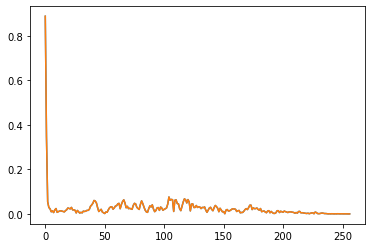

In [9]:
plt.plot(np.abs(out_rfft))
plt.plot(np.abs(out_rfft_np))

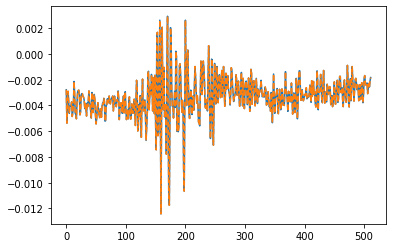

In [10]:
plt.plot(out_iwindow_c)
plt.plot(frame, '--')

In [11]:
# FLOAT 16

In [12]:
out_window_c = np.array([
		-0.000222, -0.000431, -0.000271, -0.000232, -0.000296, -0.000374, -0.000328, -0.000332, -0.000328, -0.000309, -0.000404, -0.000380, -0.000330, -0.000183, -0.000267, -0.000404, -0.000418, -0.000452, -0.000345, -0.000273, -0.000267, -0.000267, -0.000307, -0.000463, -0.000448, -0.000326, -0.000319, -0.000324, -0.000353, -0.000366, -0.000395, -0.000479, -0.000443, -0.000504, -0.000576, -0.000465, -0.000507, -0.000462, -0.000370, -0.000492, -0.000534, -0.000614, -0.000694, -0.000427, -0.000507, -0.000675, -0.000507, -0.000484, -0.000565, -0.000763, -0.000893, -0.000847, -0.000710, -0.000656, -0.000793, -0.000854, -0.000912, -0.000805, -0.000820, -0.000965, -0.000809, -0.000774, -0.000816, -0.000729, -0.000786, -0.001144, -0.001160, -0.000904, -0.000912, -0.000824, -0.000889, -0.000923, -0.000813, -0.000954, -0.000999, -0.000927, -0.000923, -0.000912, -0.000900, -0.001244, -0.001091, -0.000942, -0.001137, -0.001175, -0.001244, -0.001099, -0.001160, -0.000912, -0.001129, -0.001671, -0.001404, -0.001297, -0.001427, -0.001320, -0.001640, -0.001328, -0.001190, -0.001701, -0.001175, -0.001114, -0.001640, -0.001984, -0.001938, -0.001755, -0.002060, -0.001518, -0.001389, -0.001984, -0.002182, -0.002121, -0.001701, -0.001930, -0.002075, -0.001884, -0.001625, -0.002151, -0.002640, -0.001709, -0.000992, -0.001358, -0.002960, -0.002762, -0.001999, -0.002472, -0.001678, -0.002274, -0.003433, -0.001930, -0.001060, -0.002182, -0.002441, -0.002014, -0.002014, -0.002808, -0.003860, -0.003265, -0.002670, -0.000923, -0.000801, -0.002609, -0.002045, -0.001572, -0.001953, -0.000992, -0.001564, -0.002823, -0.001175, -0.002274, -0.003021, -0.001091, -0.003693, -0.004974, 0.001030, 0.001144, -0.004364, -0.004242, -0.001060, 0.001846, -0.003189, -0.008850, -0.002945, 0.001503, -0.002365, -0.003189, -0.000767, -0.003632, -0.003326, -0.002975, -0.005890, -0.000443, 0.002258, -0.003662, -0.008362, -0.009155, -0.003876, 0.001625, 0.000900, -0.002151, -0.003265, -0.003250, -0.004059, -0.003128, -0.002396, -0.003433, 0.000177, -0.000178, -0.005066, -0.003830, -0.005157, -0.004822, -0.000759, -0.000660, -0.001457, -0.002899, -0.003967, -0.003159, -0.003616, -0.007996, -0.009460, -0.002869, 0.002365, -0.000965, -0.003601, -0.000610, 0.000278, -0.001785, -0.004242, -0.004608, -0.003235, -0.002594, -0.003098, -0.004395, -0.003540, -0.003067, -0.004120, -0.002594, -0.000923, -0.001595, -0.002731, -0.003632, -0.003098, -0.003815, -0.005066, -0.005188, -0.005402, -0.003159, -0.000534, -0.000950, -0.003052, -0.001968, -0.000538, -0.001076, -0.002060, -0.004028, -0.004150, -0.003479, -0.003891, -0.004364, -0.001953, 0.000637, -0.001663, -0.004822, -0.006500, -0.005127, -0.000395, -0.000486, -0.005402, -0.007050, -0.003677, -0.000732, -0.002472, -0.003876, -0.002319, -0.000977, -0.002197, -0.003784, -0.002380, -0.001617, -0.002106, -0.003387, -0.002319, -0.001282, -0.003326, -0.002090, -0.000973, -0.002365, -0.004028, -0.003281, -0.001488, -0.002701, -0.002640, -0.001663, -0.002579, -0.002930, -0.003082, -0.003906, -0.003067, -0.001053, -0.001228, -0.002426, -0.002960, -0.003601, -0.003281, -0.003113, -0.002823, -0.001564, -0.001953, -0.003098, -0.002655, -0.002029, -0.003220, -0.003891, -0.003342, -0.002441, -0.001358, -0.002884, -0.003815, -0.001778, -0.002625, -0.003967, -0.002731, -0.002106, -0.001953, -0.002502, -0.003632, -0.003357, -0.001701, -0.002670, -0.004028, -0.003082, -0.001076, -0.001343, -0.003494, -0.002640, -0.001869, -0.001831, -0.002274, -0.003525, -0.003082, -0.001640, -0.002548, -0.003311, -0.002319, -0.002853, -0.002563, -0.002472, -0.002197, -0.001701, -0.002228, -0.002747, -0.002686, -0.002548, -0.002731, -0.002289, -0.002060, -0.002243, -0.003143, -0.003082, -0.002670, -0.002274, -0.002808, -0.003174, -0.002899, -0.003372, -0.002258, -0.002533, -0.003967, -0.002655, -0.001144, -0.002167, -0.003326, -0.002472, -0.002319, -0.002090, -0.001892, -0.002930, -0.003204, -0.002457, -0.001869, -0.002228, -0.002899, -0.002640, -0.001793, -0.001869, -0.002579, -0.002548, -0.002548, -0.001816, -0.000858, -0.001709, -0.001945, -0.002151, -0.002686, -0.001732, -0.001755, -0.002167, -0.002121, -0.002136, -0.001289, -0.001892, -0.002609, -0.002045, -0.001656, -0.001793, -0.002426, -0.002090, -0.000992, -0.001312, -0.002579, -0.002029, -0.000946, -0.000652, -0.000645, -0.001297, -0.001724, -0.001419, -0.001305, -0.001579, -0.001663, -0.001572, -0.001396, -0.001419, -0.001343, -0.001129, -0.001472, -0.001427, -0.001343, -0.001358, -0.001213, -0.000957, -0.001236, -0.001450, -0.000790, -0.001236, -0.001099, -0.000782, -0.001129, -0.001038, -0.001343, -0.001419, -0.001038, -0.000439, -0.000660, -0.001404, -0.000931, -0.000931, -0.000885, -0.000484, -0.000793, -0.001060, -0.001091, -0.000660, -0.000360, -0.000748, -0.001038, -0.000793, -0.000912, -0.000961, -0.000595, -0.000652, -0.000767, -0.000710, -0.000599, -0.000599, -0.000896, -0.000847, -0.000710, -0.000877, -0.000805, -0.000656, -0.000441, -0.000675, -0.000767, -0.000557, -0.000483, -0.000378, -0.000683, -0.000626, -0.000414, -0.000298, -0.000292, -0.000492, -0.000467, -0.000416, -0.000557, -0.000618, -0.000366, -0.000294, -0.000435, -0.000507, -0.000515, -0.000317, -0.000117, -0.000259, -0.000484, -0.000511, -0.000336, -0.000230, -0.000425, -0.000278, -0.000110, -0.000227, -0.000313, -0.000391, -0.000305, -0.000209, -0.000193, -0.000223, -0.000273, -0.000230, -0.000254, -0.000340, -0.000271, -0.000217, -0.000319, -0.000290, -0.000196, -0.000277, -0.000324, -0.000269, -0.000161, -0.000140, -0.000182, -0.000197, -0.000189, -0.000183, -0.000250, -0.000216, -0.000183, -0.000205, -0.000166, -0.000147, ])

out_swapped_fft = np.array([
	-0.445312-0.445312j, 0.147461+0.195312j, 0.027344+0.026611j, -0.018555-0.007324j, 0.015381-0.005249j, -0.006226+0.001709j, -0.005676+0.007507j, 0.003937+0.000122j, 0.009766-0.005981j, -0.016113-0.002380j, 0.004730-0.000366j, -0.000183+0.006958j, 0.000488-0.007629j, -0.005249+0.007202j, 0.007202+0.004395j, -0.005798-0.005188j, 0.002075-0.005859j, -0.003784+0.008789j, 0.011292-0.002319j, -0.016357-0.003174j, 0.012207+0.009766j, -0.008911-0.011719j, 0.004517+0.016235j, 0.000977-0.008545j, -0.007751-0.004639j, 0.007935+0.007080j, 0.001068+0.001648j, -0.007599-0.007172j, 0.006775+0.007202j, -0.000992-0.007935j, -0.004883+0.000366j, 0.003479+0.005310j, -0.004242-0.003815j, 0.003235+0.001221j, 0.000732-0.006287j, -0.004456+0.004395j, 0.008057+0.000488j, -0.010071+0.000305j, 0.016235+0.003418j, -0.017334-0.016357j, -0.002319+0.023315j, 0.022827-0.013672j, -0.020874-0.005463j, 0.010864+0.019531j, -0.003937-0.010864j, -0.002563+0.001251j, 0.004395-0.008301j, -0.004150+0.014648j, 0.005371-0.008606j, -0.008057-0.003662j, 0.004517+0.007751j, 0.005402-0.001465j, -0.006866-0.004028j, -0.001099+0.014771j, 0.013000-0.016235j, -0.024536+0.002991j, 0.018433+0.009277j, 0.000549-0.017334j, -0.010376+0.018921j, 0.019653-0.004272j, -0.022095-0.015991j, 0.011963+0.026611j, -0.004028-0.022949j, -0.005371+0.006836j, 0.008789+0.011230j, 0.005859-0.022583j, -0.027100+0.020264j, 0.022705+0.000549j, 0.004089-0.019287j, -0.019043+0.014526j, 0.011230+0.003906j, 0.006104-0.010864j, -0.011047-0.005737j, 0.001877+0.016235j, -0.004456-0.005066j, 0.006836-0.004822j, -0.003235-0.007019j, -0.009155+0.014526j, 0.023438-0.001312j, -0.016602-0.005341j, 0.002136+0.011597j, 0.005524-0.008057j, 0.004150-0.014282j, -0.029053+0.021851j, 0.038086-0.000397j, -0.018188-0.018311j, -0.010986+0.014771j, 0.017456-0.001587j, -0.005005-0.010010j, 0.004333+0.004089j, -0.012085+0.008423j, 0.009277-0.005951j, 0.000404+0.004211j, 0.001038-0.018066j, -0.009155+0.017334j, 0.011230+0.002441j, -0.012939-0.017944j, 0.022705+0.009949j, -0.021484-0.010864j, 0.009033+0.017822j, 0.007507-0.012939j, -0.012695-0.003067j, 0.001129+0.014465j, 0.017944-0.016113j, -0.021973+0.009521j, 0.006256+0.006805j, 0.011230-0.015198j, -0.015869+0.000488j, -0.012573+0.013245j, 0.029541-0.012085j, -0.011963-0.011597j, -0.018677+0.021484j, 0.033691+0.006775j, -0.013672-0.035156j, -0.017212+0.020508j, 0.012817+0.004791j, 0.019287-0.012695j, -0.033203-0.002167j, 0.026855+0.014465j, -0.013550-0.014099j, -0.002502+0.008545j, -0.008972-0.012390j, 0.025757+0.017578j, -0.004150-0.028442j, -0.024902+0.014343j, 0.015747+0.017212j, 0.019409-0.024658j, -0.031738+0.003906j, 0.016602+0.023438j, 0.004883-0.037598j, 0.000305+0.028564j, -0.017334-0.023682j, 0.022705+0.039551j, -0.005554-0.043701j, -0.011169+0.007751j, -0.005402+0.054199j, 0.033203-0.054199j, -0.047363-0.010681j, 0.019775+0.059082j, 0.029297-0.058594j, -0.045898+0.025391j, 0.030151-0.014282j, -0.005615+0.015869j, 0.013000-0.020264j, -0.034180+0.026611j, 0.044434+0.001404j, -0.032227-0.053223j, -0.007568+0.057861j, 0.009521+0.003632j, 0.031128-0.054688j, -0.056641+0.028442j, 0.048584+0.035889j, -0.023193-0.070312j, -0.000397+0.042236j, 0.013672-0.021973j, -0.021729+0.010132j, 0.020264+0.009888j, -0.002243-0.018188j, -0.024170+0.007690j, 0.028809+0.003342j, 0.001312-0.012817j, -0.022705+0.016602j, 0.021240-0.009705j, -0.011414+0.001404j, -0.001312-0.010498j, -0.010925+0.016357j, 0.031128-0.023193j, -0.032471+0.005920j, 0.023560+0.031982j, -0.009399-0.027100j, -0.009155-0.002106j, 0.001434+0.013672j, 0.017334-0.007568j, -0.033203-0.009399j, 0.014038+0.045898j, 0.029053-0.057129j, -0.044922+0.017090j, 0.017090+0.020020j, 0.026001-0.008972j, -0.020996-0.023682j, -0.015137+0.044922j, 0.041992-0.032227j, -0.038818+0.006256j, 0.010620+0.013855j, 0.018188-0.014038j, -0.022461-0.007568j, -0.002106+0.021606j, 0.020386-0.018921j, -0.019165-0.014771j, -0.000061+0.044189j, 0.036133-0.041504j, -0.050537-0.000977j, 0.032227+0.022949j, 0.012207-0.018677j, -0.039795-0.012939j, 0.024414+0.028320j, -0.008240-0.027832j, -0.005066+0.029419j, 0.012939-0.015503j, -0.015625-0.003204j, 0.014343+0.021606j, -0.003098-0.023315j, -0.012024+0.016357j, 0.010986-0.008118j, -0.005188-0.000320j, 0.010376-0.004028j, -0.003601+0.000031j, -0.004211+0.003937j, -0.001038+0.005280j, 0.013794-0.007477j, -0.013428+0.001312j, 0.011475+0.003540j, -0.023193-0.012817j, 0.023804+0.038330j, 0.002960-0.055176j, -0.030884+0.044434j, 0.039551-0.014526j, -0.026367-0.019287j, 0.012451+0.027222j, -0.004486-0.016724j, -0.002838+0.013855j, 0.012329-0.008362j, -0.010864-0.000488j, 0.003906+0.010376j, 0.000214-0.012329j, -0.001221+0.002991j, 0.000061-0.005371j, 0.002228+0.003845j, 0.001160+0.004639j, -0.008057-0.008789j, 0.003754+0.001892j, 0.006592+0.011047j, -0.003418-0.015381j, -0.015259+0.006195j, 0.024170+0.002136j, -0.012512-0.012085j, 0.009766+0.016113j, -0.002686-0.020874j, -0.002808+0.014648j, 0.009766-0.005432j, -0.006958+0.002869j, -0.004639-0.006592j, 0.005157+0.007996j, 0.009155-0.006012j, -0.010010+0.000305j, 0.007690+0.000275j, 0.001038+0.005066j, -0.002808-0.017578j, -0.007263+0.010620j, 0.001663+0.004333j, 0.007690-0.006348j, 0.001709-0.006714j, -0.005127+0.015869j, -0.007721-0.019653j, 0.027466+0.027832j, 0.197266+0.148438j, ])

out_rfft = np.array([
	-0.890625+0.000000j, 0.343750+0.046387j, 0.054688-0.001221j, -0.026367+0.012085j, 0.009949-0.020996j, -0.004517+0.008301j, 0.002075+0.013550j, 0.004944-0.003418j, 0.002716-0.017090j, -0.018677+0.015259j, 0.005005-0.004822j, 0.007874+0.006775j, -0.009155-0.008606j, 0.003693+0.013611j, 0.012085-0.003876j, -0.010925+0.002350j, -0.004791-0.008484j, 0.006042+0.013428j, 0.008667-0.016724j, -0.019653+0.018311j, 0.023193-0.007507j, -0.022705+0.001457j, 0.025879+0.014038j, -0.010559-0.014893j, -0.014526+0.010376j, 0.015625-0.005371j, 0.004517+0.000595j, -0.015442+0.003189j, 0.008606-0.003357j, -0.000740-0.003662j, -0.003860+0.006073j, 0.004120-0.002563j, -0.008545+0.009399j, 0.009033-0.006561j, -0.010498-0.006836j, 0.005646+0.014893j, 0.006775-0.014648j, -0.013428+0.014648j, 0.027222-0.020508j, -0.039551+0.005707j, 0.032227+0.035400j, -0.003540-0.060059j, -0.029541+0.050293j, 0.045654-0.018433j, -0.028687-0.001221j, 0.010193+0.003586j, -0.012207-0.010498j, 0.012756+0.016602j, -0.000992-0.008728j, -0.004944-0.002289j, 0.001297-0.001694j, 0.007111+0.004913j, -0.007294+0.000114j, 0.011230+0.014282j, -0.007172-0.026367j, -0.015015+0.027954j, 0.027100-0.017578j, -0.020630-0.006622j, 0.010193+0.024902j, 0.008545-0.034424j, -0.026855+0.025879j, 0.042480-0.014954j, -0.047119-0.005554j, 0.005310+0.023193j, 0.041016-0.009644j, -0.050781-0.022217j, 0.020142+0.060547j, 0.018188-0.045898j, -0.027588+0.002655j, 0.014038+0.031494j, 0.007812-0.022827j, -0.025024-0.003815j, 0.008667+0.021118j, 0.019043-0.007782j, -0.034912-0.016846j, 0.027222+0.039062j, -0.002716-0.044922j, -0.022583+0.019287j, 0.022705+0.008728j, 0.018311-0.009216j, -0.033203-0.027832j, 0.009277+0.058594j, 0.021729-0.040771j, -0.029663+0.009216j, 0.016724+0.001648j, -0.001038-0.009033j, -0.006134+0.003357j, -0.014648+0.018799j, 0.027100-0.023926j, -0.028076-0.013855j, 0.025513+0.032227j, -0.007660-0.020264j, -0.002579+0.009827j, -0.014343-0.004791j, 0.021484+0.016235j, -0.017578-0.022461j, -0.005096+0.014282j, 0.031006-0.001770j, -0.024658-0.008301j, -0.001953+0.016235j, 0.019409-0.007812j, -0.020386-0.011414j, 0.012207+0.023682j, 0.004028-0.044434j, -0.031982+0.068848j, 0.053711-0.029175j, -0.053711-0.037109j, 0.023438+0.059814j, 0.011169-0.000671j, -0.001770-0.061523j, -0.039062+0.050293j, 0.046143+0.005310j, -0.030151-0.032715j, 0.007721+0.022217j, -0.002625-0.014648j, 0.029297+0.015625j, -0.044434-0.030151j, 0.024902+0.062500j, 0.024292-0.059570j, -0.048584+0.008667j, 0.030762+0.055664j, -0.003632-0.053711j, -0.010010-0.009033j, -0.007751+0.043701j, 0.024048-0.038330j, -0.017578+0.023193j, 0.000427-0.028809j, 0.004639+0.037842j, 0.016602-0.023438j, -0.031494-0.003662j, 0.019287+0.024414j, 0.015869-0.017822j, -0.026245-0.013184j, -0.001938+0.028564j, 0.024658-0.018921j, -0.010742+0.012573j, -0.000061-0.006836j, -0.012451+0.012085j, 0.022339-0.014771j, -0.028809+0.006226j, 0.017944+0.007935j, 0.013672-0.003448j, -0.020264-0.019287j, -0.008423+0.037109j, 0.029663-0.013062j, -0.020264-0.014709j, -0.005127+0.008789j, 0.023682+0.008301j, -0.014221-0.010315j, -0.008240+0.004639j, 0.008301+0.006470j, 0.001221-0.000122j, -0.013123-0.011108j, 0.013550+0.013916j, 0.002594-0.012634j, -0.014099+0.001770j, 0.008423+0.015015j, 0.008728-0.019897j, -0.020996+0.010254j, 0.020508-0.008362j, -0.006500+0.019409j, 0.006104-0.008301j, -0.009399-0.010864j, 0.003967+0.014771j, 0.001663-0.004883j, 0.006012+0.002014j, -0.006470+0.000488j, 0.000000-0.012024j, -0.008545+0.018066j, 0.022705-0.006653j, -0.014038-0.013489j, -0.015625+0.022949j, 0.038574-0.005524j, -0.032715-0.021973j, -0.003601+0.019287j, 0.025391+0.009399j, -0.009644-0.022217j, -0.017822+0.016113j, 0.026611+0.001083j, -0.007568-0.018799j, -0.015625+0.007202j, 0.021606+0.011719j, -0.008362-0.005432j, -0.006561-0.010132j, -0.001526+0.012817j, 0.008667-0.000519j, 0.001312-0.005127j, -0.012695-0.001953j, 0.012451+0.007172j, 0.004517-0.002197j, -0.011108-0.001343j, 0.005981-0.000549j, 0.000122+0.002075j, 0.001526-0.002319j, 0.003174+0.004456j, -0.006226-0.013245j, -0.003418+0.013977j, 0.006073-0.000732j, -0.007629-0.009460j, 0.005524+0.007538j, 0.005676-0.005188j, -0.012573+0.001587j, 0.008179+0.006409j, -0.001373-0.008667j, -0.004791+0.003815j, 0.008667+0.002350j, -0.000381-0.009399j, -0.007324+0.005310j, 0.005310+0.005219j, -0.003113-0.005493j, 0.003174-0.000824j, -0.001282+0.005859j, 0.001587-0.003174j, -0.010986+0.000366j, 0.011536+0.000366j, -0.004517-0.001831j, 0.004761-0.002441j, -0.004028+0.002777j, 0.001465+0.003296j, -0.001129-0.002441j, -0.001541-0.001312j, 0.002228+0.002106j, 0.000366-0.001038j, -0.001862+0.002594j, 0.004547+0.000854j, -0.001862-0.004883j, -0.000961+0.000336j, 0.001984+0.008118j, -0.000671-0.005920j, -0.000183+0.001572j, 0.000305+0.000839j, -0.001160-0.001389j, 0.003387-0.000366j, -0.003738-0.000092j, 0.002869-0.000031j, 0.001221+0.001091j, -0.001221-0.001160j, 0.000610+0.000549j, -0.000214+0.000244j, -0.000061-0.000824j, -0.000092+0.000244j, 0.000488+0.000946j, 0.000244-0.000275j, 0.000221+0.000427j, -0.000366-0.000671j, -0.000366+0.000076j, 0.000778+0.000595j, -0.000244+0.000092j, -0.000214-0.000427j, 0.000687+0.000786j, -0.000061-0.000305j, 0.000000-0.000092j, 0.000305+0.000061j, 0.000183-0.000244j, 0.000122+0.000004j, 0.000000-0.000610j, 0.000000+0.000000j, ])


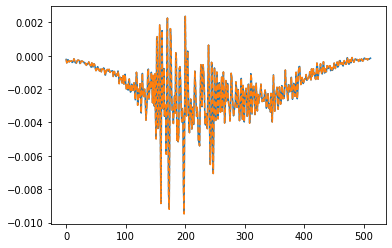

In [18]:
plt.plot(out_window_c)
plt.plot(win_frame, '--')

In [19]:

in_ifft = np.array([
	-0.445312-0.445312j, 0.146484+0.195312j, 0.027344+0.026733j, -0.018555-0.007385j, 0.015381-0.005157j, -0.006195+0.001709j, -0.005676+0.007507j, 0.003937+0.000122j, 0.009888-0.005981j, -0.016113-0.002441j, 0.004730-0.000366j, -0.000183+0.006989j, 0.000458-0.007629j, -0.005249+0.007202j, 0.007202+0.004395j, -0.005798-0.005219j, 0.002045-0.005859j, -0.003784+0.008789j, 0.011292-0.002319j, -0.016357-0.003113j, 0.012207+0.009705j, -0.008911-0.011719j, 0.004578+0.016113j, 0.001038-0.008545j, -0.007751-0.004700j, 0.007935+0.007111j, 0.001068+0.001648j, -0.007568-0.007202j, 0.006775+0.007202j, -0.000992-0.007935j, -0.004883+0.000366j, 0.003479+0.005310j, -0.004211+0.003723j, 0.003265-0.001190j, 0.000732+0.006287j, -0.004486-0.004456j, 0.008057-0.000488j, -0.010010-0.000366j, 0.016235-0.003479j, -0.017334+0.016235j, -0.002441-0.023315j, 0.022827+0.013672j, -0.020996+0.005371j, 0.010864-0.019531j, -0.003845+0.010864j, -0.002563-0.001274j, 0.004395+0.008301j, -0.004211-0.014648j, 0.005371+0.008606j, -0.008057+0.003662j, 0.004517-0.007721j, 0.005371+0.001465j, -0.006897+0.004028j, -0.001099-0.014771j, 0.013123+0.016235j, -0.024536-0.002991j, 0.018311-0.009277j, 0.000488+0.017334j, -0.010376-0.018921j, 0.019775+0.004272j, -0.021973+0.015991j, 0.011841-0.026733j, -0.004272+0.022827j, -0.005371-0.006805j, 0.008667-0.011353j, 0.005737+0.022461j, -0.026978-0.020386j, 0.022705-0.000488j, 0.003967+0.019287j, -0.019043-0.014465j, 0.011230-0.003906j, 0.006104+0.010864j, -0.011108+0.005737j, 0.001831-0.016235j, -0.004272+0.005157j, 0.006836+0.004883j, -0.003204+0.007080j, -0.009155-0.014465j, 0.023438+0.001312j, -0.016602+0.005280j, 0.002197-0.011536j, 0.005554+0.008057j, 0.004028+0.014160j, -0.029175-0.021851j, 0.038086+0.000381j, -0.018066+0.018311j, -0.011047-0.014771j, 0.017456+0.001648j, -0.005066+0.010010j, 0.004395-0.004089j, -0.012085-0.008423j, 0.009277+0.005859j, 0.000397-0.004211j, 0.001099+0.018066j, -0.009155-0.017334j, 0.011230-0.002319j, -0.012878+0.017822j, 0.022705-0.009949j, -0.021484+0.010864j, 0.009033-0.017944j, 0.007538+0.012939j, -0.012695+0.003067j, 0.001068-0.014465j, 0.017944+0.016113j, -0.021973-0.009766j, 0.006226-0.006958j, 0.011230+0.015198j, -0.015991-0.000366j, -0.012512-0.013245j, 0.029541+0.011963j, -0.011963+0.011719j, -0.018555-0.021484j, 0.033447-0.006775j, -0.013733+0.035156j, -0.017212-0.020508j, 0.012817-0.004730j, 0.019287+0.012634j, -0.033203+0.002441j, 0.026855-0.014404j, -0.013672+0.014038j, -0.002319-0.008423j, -0.008972+0.012451j, 0.025513-0.017578j, -0.004150+0.028809j, -0.025024-0.014404j, 0.015747-0.017212j, 0.019287+0.024658j, -0.031738-0.003906j, 0.016602-0.023438j, 0.004883+0.037598j, 0.000427-0.028564j, -0.017456+0.023804j, 0.022827-0.039551j, -0.005554+0.043945j, -0.010864-0.007690j, -0.005432-0.053955j, 0.033203+0.054199j, -0.047363+0.010620j, 0.019775-0.059326j, 0.029297+0.058594j, -0.045654-0.025391j, 0.030151+0.014282j, -0.005707-0.015869j, 0.013000+0.020264j, -0.033936-0.026367j, 0.044434-0.001465j, -0.032227+0.053223j, -0.007568-0.057861j, 0.009460-0.003601j, 0.031128+0.054688j, -0.056641-0.028320j, 0.048828-0.036133j, -0.023193+0.070312j, -0.000366-0.042236j, 0.013672+0.021973j, -0.021729-0.010132j, 0.020264-0.009888j, -0.002258+0.018188j, -0.024170-0.007690j, 0.028809-0.003357j, 0.001282+0.012695j, -0.022705-0.016479j, 0.021240+0.009705j, -0.011475-0.001404j, -0.001312+0.010498j, -0.010986-0.016357j, 0.031128+0.023315j, -0.032471-0.005920j, 0.023682-0.031982j, -0.009399+0.027100j, -0.009094+0.002045j, 0.001465-0.013672j, 0.017212+0.007568j, -0.033203+0.009399j, 0.014038-0.045898j, 0.029053+0.057373j, -0.045166-0.017090j, 0.017090-0.020142j, 0.025879+0.008911j, -0.020996+0.023682j, -0.015137-0.045166j, 0.041992+0.032227j, -0.039062-0.006256j, 0.010620-0.013855j, 0.018188+0.014038j, -0.022461+0.007568j, -0.002075-0.021606j, 0.020508+0.019043j, -0.019043+0.014832j, 0.000000-0.044189j, 0.036133+0.041504j, -0.050781+0.000793j, 0.032227-0.023071j, 0.012207+0.018677j, -0.039551+0.012817j, 0.024292-0.028442j, -0.008240+0.027954j, -0.005066-0.029419j, 0.012939+0.015503j, -0.015625+0.003235j, 0.014404-0.021729j, -0.003052+0.023438j, -0.012146-0.016479j, 0.010986+0.008179j, -0.005188+0.000320j, 0.010376+0.004028j, -0.003601-0.000031j, -0.004211-0.003937j, -0.001038-0.005310j, 0.013855+0.007446j, -0.013428-0.001358j, 0.011475-0.003540j, -0.023193+0.012817j, 0.023804-0.038330j, 0.002991+0.055176j, -0.030884-0.044434j, 0.039551+0.014526j, -0.026123+0.019165j, 0.012451-0.027344j, -0.004486+0.016724j, -0.002808-0.013794j, 0.012329+0.008362j, -0.010864+0.000473j, 0.003906-0.010376j, 0.000229+0.012268j, -0.001221-0.002991j, 0.000061+0.005371j, 0.002243-0.003845j, 0.001160-0.004639j, -0.008057+0.008789j, 0.003754-0.001892j, 0.006531-0.011108j, -0.003372+0.015442j, -0.015320-0.006195j, 0.024170-0.002136j, -0.012573+0.012085j, 0.009766-0.016113j, -0.002716+0.020996j, -0.002869-0.014648j, 0.009766+0.005463j, -0.006927-0.002869j, -0.004639+0.006622j, 0.005127-0.007996j, 0.009155+0.005981j, -0.010010-0.000305j, 0.007690-0.000275j, 0.001068-0.005066j, -0.002838+0.017578j, -0.007355-0.010620j, 0.001686-0.004333j, 0.007690+0.006348j, 0.001678+0.006714j, -0.005127-0.015869j, -0.007629+0.019775j, 0.027344-0.027954j, 0.197266-0.148438j, ])

out_swapped_fft = np.array([
	-0.000244-0.000423j, -0.000290-0.000244j, -0.000320-0.000385j, -0.000336-0.000340j, -0.000347-0.000305j, -0.000397-0.000412j, -0.000324-0.000168j, -0.000252-0.000404j, -0.000420-0.000465j, -0.000366-0.000275j, -0.000282-0.000265j, -0.000290-0.000462j, -0.000443-0.000336j, -0.000351-0.000313j, -0.000359-0.000359j, -0.000412-0.000473j, -0.000465-0.000519j, -0.000603-0.000458j, -0.000488-0.000481j, -0.000380-0.000511j, -0.000572-0.000595j, -0.000740-0.000458j, -0.000473-0.000633j, -0.000504-0.000496j, -0.000580-0.000763j, -0.000919-0.000835j, -0.000755-0.000671j, -0.000797-0.000866j, -0.000931-0.000809j, -0.000858-0.000977j, -0.000820-0.000778j, -0.000839-0.000751j, -0.000801-0.001152j, -0.001160-0.000912j, -0.000908-0.000862j, -0.000893-0.000916j, -0.000805-0.000942j, -0.001030-0.000938j, -0.000916-0.000969j, -0.000912-0.001236j, -0.001099-0.000954j, -0.001144-0.001190j, -0.001266-0.001129j, -0.001160-0.000931j, -0.001129-0.001678j, -0.001434-0.001282j, -0.001419-0.001343j, -0.001640-0.001335j, -0.001205-0.001717j, -0.001190-0.001099j, -0.001648-0.001999j, -0.001945-0.001755j, -0.002075-0.001518j, -0.001419-0.001984j, -0.002151-0.002151j, -0.001694-0.001953j, -0.002060-0.001892j, -0.001610-0.002151j, -0.002640-0.001732j, -0.000984-0.001350j, -0.002991-0.002777j, -0.001999-0.002472j, -0.001678-0.002289j, -0.003433-0.001923j, -0.001068-0.002197j, -0.002441-0.002014j, -0.001999-0.002808j, -0.003860-0.003265j, -0.002686-0.000938j, -0.000828-0.002640j, -0.002060-0.001572j, -0.001953-0.000992j, -0.001572-0.002838j, -0.001175-0.002289j, -0.003036-0.001099j, -0.003677-0.004974j, 0.001007+0.001106j, -0.004395-0.004211j, -0.001060+0.001831j, -0.003174-0.008911j, -0.002991+0.001472j, -0.002365-0.003174j, -0.000778-0.003662j, -0.003357-0.002975j, -0.005920-0.000469j, 0.002228-0.003662j, -0.008362-0.009155j, -0.003876+0.001633j, 0.000916-0.002151j, -0.003265-0.003250j, -0.004089-0.003113j, -0.002396-0.003433j, 0.000160-0.000198j, -0.005066-0.003830j, -0.005188-0.004822j, -0.000790-0.000675j, -0.001465-0.002914j, -0.003967-0.003143j, -0.003677-0.008057j, -0.009399-0.002838j, 0.002350-0.000992j, -0.003601-0.000629j, 0.000265-0.001801j, -0.004211-0.004578j, -0.003265-0.002609j, -0.003082-0.004395j, -0.003571-0.003098j, -0.004089-0.002579j, -0.000938-0.001633j, -0.002747-0.003601j, -0.003113-0.003815j, -0.005066-0.005188j, -0.005402-0.003174j, -0.000530-0.000935j, -0.003052-0.002014j, -0.000538-0.001060j, -0.002075-0.004028j, -0.004150-0.003479j, -0.003891-0.004333j, -0.001938+0.000648j, -0.001663-0.004822j, -0.006470-0.005127j, -0.000420-0.000504j, -0.005371-0.007019j, -0.003693-0.000740j, -0.002472-0.003830j, -0.002319-0.001007j, -0.002197-0.003799j, -0.002411-0.001617j, -0.002090-0.003372j, -0.002335-0.001282j, -0.003326-0.002075j, -0.000977-0.002350j, -0.004028-0.003281j, -0.001526-0.002731j, -0.002625-0.001656j, -0.002594-0.002899j, -0.003082-0.003906j, -0.003082-0.001068j, -0.001205-0.002411j, -0.002975-0.003632j, -0.003250-0.003082j, -0.002838-0.001587j, -0.001938-0.003098j, -0.002686-0.002029j, -0.003204-0.003876j, -0.003342-0.002441j, -0.001343-0.002869j, -0.003784-0.001785j, -0.002594-0.003967j, -0.002731-0.002075j, -0.001968-0.002502j, -0.003632-0.003326j, -0.001709-0.002655j, -0.004028-0.003098j, -0.001083-0.001343j, -0.003494-0.002655j, -0.001846-0.001801j, -0.002258-0.003555j, -0.003067-0.001648j, -0.002563-0.003296j, -0.002319-0.002838j, -0.002563-0.002502j, -0.002167-0.001678j, -0.002228-0.002716j, -0.002655-0.002563j, -0.002762-0.002319j, -0.002029-0.002213j, -0.003143-0.003082j, -0.002655-0.002274j, -0.002823-0.003204j, -0.002899-0.003342j, -0.002274-0.002533j, -0.003937-0.002655j, -0.001114-0.002167j, -0.003296-0.002502j, -0.002319-0.002075j, -0.001892-0.002930j, -0.003204-0.002457j, -0.001854-0.002213j, -0.002869-0.002625j, -0.001755-0.001892j, -0.002579-0.002518j, -0.002548-0.001823j, -0.000866-0.001678j, -0.001945-0.002121j, -0.002670-0.001778j, -0.001732-0.002167j, -0.002136-0.002136j, -0.001297-0.001869j, -0.002594-0.002075j, -0.001633-0.001785j, -0.002441-0.002106j, -0.000984-0.001320j, -0.002579-0.002014j, -0.000961-0.000641j, -0.000633-0.001289j, -0.001740-0.001419j, -0.001312-0.001572j, -0.001625-0.001556j, -0.001404-0.001411j, -0.001328-0.001114j, -0.001480-0.001434j, -0.001358-0.001373j, -0.001221-0.000938j, -0.001236-0.001419j, -0.000801-0.001236j, -0.001099-0.000763j, -0.001137-0.001045j, -0.001358-0.001396j, -0.001038-0.000435j, -0.000671-0.001389j, -0.000946-0.000927j, -0.000877-0.000519j, -0.000793-0.001007j, -0.001106-0.000660j, -0.000351-0.000748j, -0.001038-0.000778j, -0.000954-0.000969j, -0.000576-0.000687j, -0.000771-0.000732j, -0.000626-0.000595j, -0.000885-0.000854j, -0.000721-0.000866j, -0.000793-0.000641j, -0.000443-0.000679j, -0.000778-0.000549j, -0.000519-0.000397j, -0.000710-0.000599j, -0.000420-0.000324j, -0.000280-0.000473j, -0.000473-0.000443j, -0.000557-0.000626j, -0.000359-0.000305j, -0.000458-0.000504j, -0.000519-0.000290j, -0.000114-0.000244j, -0.000488-0.000519j, -0.000336-0.000244j, -0.000427-0.000305j, -0.000153-0.000237j, -0.000324-0.000393j, -0.000290-0.000233j, -0.000179-0.000221j, -0.000290-0.000229j, -0.000290-0.000366j, -0.000290-0.000229j, -0.000347-0.000277j, -0.000195-0.000275j, -0.000351-0.000259j, -0.000175-0.000135j, -0.000214-0.000183j, -0.000214-0.000208j, -0.000267-0.000198j, -0.000175-0.000217j, -0.000175-0.000137j, ])

out_irfft = np.array([
	-0.000244, -0.000423, -0.000290, -0.000244, -0.000320, -0.000385, -0.000336, -0.000340, -0.000347, -0.000305, -0.000397, -0.000412, -0.000324, -0.000168, -0.000252, -0.000404, -0.000420, -0.000465, -0.000366, -0.000275, -0.000282, -0.000265, -0.000290, -0.000462, -0.000443, -0.000336, -0.000351, -0.000313, -0.000359, -0.000359, -0.000412, -0.000473, -0.000465, -0.000519, -0.000603, -0.000458, -0.000488, -0.000481, -0.000380, -0.000511, -0.000572, -0.000595, -0.000740, -0.000458, -0.000473, -0.000633, -0.000504, -0.000496, -0.000580, -0.000763, -0.000919, -0.000835, -0.000755, -0.000671, -0.000797, -0.000866, -0.000931, -0.000809, -0.000858, -0.000977, -0.000820, -0.000778, -0.000839, -0.000751, -0.000801, -0.001152, -0.001160, -0.000912, -0.000908, -0.000862, -0.000893, -0.000916, -0.000805, -0.000942, -0.001030, -0.000938, -0.000916, -0.000969, -0.000912, -0.001236, -0.001099, -0.000954, -0.001144, -0.001190, -0.001266, -0.001129, -0.001160, -0.000931, -0.001129, -0.001678, -0.001434, -0.001282, -0.001419, -0.001343, -0.001640, -0.001335, -0.001205, -0.001717, -0.001190, -0.001099, -0.001648, -0.001999, -0.001945, -0.001755, -0.002075, -0.001518, -0.001419, -0.001984, -0.002151, -0.002151, -0.001694, -0.001953, -0.002060, -0.001892, -0.001610, -0.002151, -0.002640, -0.001732, -0.000984, -0.001350, -0.002991, -0.002777, -0.001999, -0.002472, -0.001678, -0.002289, -0.003433, -0.001923, -0.001068, -0.002197, -0.002441, -0.002014, -0.001999, -0.002808, -0.003860, -0.003265, -0.002686, -0.000938, -0.000828, -0.002640, -0.002060, -0.001572, -0.001953, -0.000992, -0.001572, -0.002838, -0.001175, -0.002289, -0.003036, -0.001099, -0.003677, -0.004974, 0.001007, 0.001106, -0.004395, -0.004211, -0.001060, 0.001831, -0.003174, -0.008911, -0.002991, 0.001472, -0.002365, -0.003174, -0.000778, -0.003662, -0.003357, -0.002975, -0.005920, -0.000469, 0.002228, -0.003662, -0.008362, -0.009155, -0.003876, 0.001633, 0.000916, -0.002151, -0.003265, -0.003250, -0.004089, -0.003113, -0.002396, -0.003433, 0.000160, -0.000198, -0.005066, -0.003830, -0.005188, -0.004822, -0.000790, -0.000675, -0.001465, -0.002914, -0.003967, -0.003143, -0.003677, -0.008057, -0.009399, -0.002838, 0.002350, -0.000992, -0.003601, -0.000629, 0.000265, -0.001801, -0.004211, -0.004578, -0.003265, -0.002609, -0.003082, -0.004395, -0.003571, -0.003098, -0.004089, -0.002579, -0.000938, -0.001633, -0.002747, -0.003601, -0.003113, -0.003815, -0.005066, -0.005188, -0.005402, -0.003174, -0.000530, -0.000935, -0.003052, -0.002014, -0.000538, -0.001060, -0.002075, -0.004028, -0.004150, -0.003479, -0.003891, -0.004333, -0.001938, 0.000648, -0.001663, -0.004822, -0.006470, -0.005127, -0.000420, -0.000504, -0.005371, -0.007019, -0.003693, -0.000740, -0.002472, -0.003830, -0.002319, -0.001007, -0.002197, -0.003799, -0.002411, -0.001617, -0.002090, -0.003372, -0.002335, -0.001282, -0.003326, -0.002075, -0.000977, -0.002350, -0.004028, -0.003281, -0.001526, -0.002731, -0.002625, -0.001656, -0.002594, -0.002899, -0.003082, -0.003906, -0.003082, -0.001068, -0.001205, -0.002411, -0.002975, -0.003632, -0.003250, -0.003082, -0.002838, -0.001587, -0.001938, -0.003098, -0.002686, -0.002029, -0.003204, -0.003876, -0.003342, -0.002441, -0.001343, -0.002869, -0.003784, -0.001785, -0.002594, -0.003967, -0.002731, -0.002075, -0.001968, -0.002502, -0.003632, -0.003326, -0.001709, -0.002655, -0.004028, -0.003098, -0.001083, -0.001343, -0.003494, -0.002655, -0.001846, -0.001801, -0.002258, -0.003555, -0.003067, -0.001648, -0.002563, -0.003296, -0.002319, -0.002838, -0.002563, -0.002502, -0.002167, -0.001678, -0.002228, -0.002716, -0.002655, -0.002563, -0.002762, -0.002319, -0.002029, -0.002213, -0.003143, -0.003082, -0.002655, -0.002274, -0.002823, -0.003204, -0.002899, -0.003342, -0.002274, -0.002533, -0.003937, -0.002655, -0.001114, -0.002167, -0.003296, -0.002502, -0.002319, -0.002075, -0.001892, -0.002930, -0.003204, -0.002457, -0.001854, -0.002213, -0.002869, -0.002625, -0.001755, -0.001892, -0.002579, -0.002518, -0.002548, -0.001823, -0.000866, -0.001678, -0.001945, -0.002121, -0.002670, -0.001778, -0.001732, -0.002167, -0.002136, -0.002136, -0.001297, -0.001869, -0.002594, -0.002075, -0.001633, -0.001785, -0.002441, -0.002106, -0.000984, -0.001320, -0.002579, -0.002014, -0.000961, -0.000641, -0.000633, -0.001289, -0.001740, -0.001419, -0.001312, -0.001572, -0.001625, -0.001556, -0.001404, -0.001411, -0.001328, -0.001114, -0.001480, -0.001434, -0.001358, -0.001373, -0.001221, -0.000938, -0.001236, -0.001419, -0.000801, -0.001236, -0.001099, -0.000763, -0.001137, -0.001045, -0.001358, -0.001396, -0.001038, -0.000435, -0.000671, -0.001389, -0.000946, -0.000927, -0.000877, -0.000519, -0.000793, -0.001007, -0.001106, -0.000660, -0.000351, -0.000748, -0.001038, -0.000778, -0.000954, -0.000969, -0.000576, -0.000687, -0.000771, -0.000732, -0.000626, -0.000595, -0.000885, -0.000854, -0.000721, -0.000866, -0.000793, -0.000641, -0.000443, -0.000679, -0.000778, -0.000549, -0.000519, -0.000397, -0.000710, -0.000599, -0.000420, -0.000324, -0.000280, -0.000473, -0.000473, -0.000443, -0.000557, -0.000626, -0.000359, -0.000305, -0.000458, -0.000504, -0.000519, -0.000290, -0.000114, -0.000244, -0.000488, -0.000519, -0.000336, -0.000244, -0.000427, -0.000305, -0.000153, -0.000237, -0.000324, -0.000393, -0.000290, -0.000233, -0.000179, -0.000221, -0.000290, -0.000229, -0.000290, -0.000366, -0.000290, -0.000229, -0.000347, -0.000277, -0.000195, -0.000275, -0.000351, -0.000259, -0.000175, -0.000135, -0.000214, -0.000183, -0.000214, -0.000208, -0.000267, -0.000198, -0.000175, -0.000217, -0.000175, -0.000137, ])
out_iwindow_c = np.array([
		-0.003052, -0.005280, -0.003632, -0.003036, -0.003998, -0.004761, -0.004120, -0.004150, -0.004242, -0.003677, -0.004761, -0.004883, -0.003815, -0.001953, -0.002899, -0.004608, -0.004730, -0.005188, -0.003998, -0.002975, -0.003021, -0.002777, -0.002991, -0.004700, -0.004425, -0.003311, -0.003403, -0.002975, -0.003357, -0.003296, -0.003708, -0.004211, -0.004028, -0.004395, -0.005035, -0.003754, -0.003937, -0.003784, -0.002930, -0.003876, -0.004242, -0.004333, -0.005310, -0.003204, -0.003250, -0.004242, -0.003326, -0.003204, -0.003677, -0.004730, -0.005615, -0.004974, -0.004425, -0.003860, -0.004486, -0.004791, -0.005035, -0.004303, -0.004486, -0.004974, -0.004089, -0.003815, -0.004028, -0.003540, -0.003723, -0.005249, -0.005188, -0.004028, -0.003906, -0.003662, -0.003708, -0.003754, -0.003250, -0.003723, -0.003998, -0.003571, -0.003433, -0.003571, -0.003311, -0.004395, -0.003845, -0.003296, -0.003876, -0.003967, -0.004150, -0.003647, -0.003693, -0.002930, -0.003494, -0.005127, -0.004303, -0.003784, -0.004120, -0.003845, -0.004639, -0.003708, -0.003296, -0.004639, -0.003159, -0.002884, -0.004272, -0.005127, -0.004883, -0.004364, -0.005096, -0.003677, -0.003387, -0.004669, -0.005005, -0.004944, -0.003830, -0.004395, -0.004578, -0.004150, -0.003464, -0.004608, -0.005554, -0.003632, -0.002029, -0.002747, -0.006042, -0.005524, -0.003937, -0.004822, -0.003235, -0.004364, -0.006470, -0.003586, -0.001968, -0.004028, -0.004425, -0.003601, -0.003540, -0.004944, -0.006683, -0.005615, -0.004578, -0.001587, -0.001381, -0.004364, -0.003372, -0.002548, -0.003143, -0.001587, -0.002487, -0.004456, -0.001823, -0.003540, -0.004639, -0.001663, -0.005554, -0.007416, 0.001495, 0.001625, -0.006409, -0.006073, -0.001526, 0.002609, -0.004486, -0.012512, -0.004150, 0.002029, -0.003250, -0.004333, -0.001053, -0.004913, -0.004486, -0.003937, -0.007812, -0.000614, 0.002899, -0.004761, -0.010803, -0.011658, -0.004913, 0.002060, 0.001152, -0.002686, -0.004059, -0.003998, -0.005005, -0.003799, -0.002899, -0.004120, 0.000193, -0.000237, -0.006012, -0.004517, -0.006134, -0.005646, -0.000919, -0.000782, -0.001694, -0.003342, -0.004517, -0.003586, -0.004181, -0.009033, -0.010559, -0.003174, 0.002625, -0.001099, -0.003998, -0.000694, 0.000292, -0.001968, -0.004608, -0.004974, -0.003540, -0.002808, -0.003326, -0.004700, -0.003815, -0.003296, -0.004333, -0.002747, -0.000992, -0.001724, -0.002869, -0.003769, -0.003265, -0.003967, -0.005249, -0.005402, -0.005615, -0.003265, -0.000546, -0.000965, -0.003128, -0.002060, -0.000549, -0.001083, -0.002106, -0.004089, -0.004211, -0.003540, -0.003937, -0.004395, -0.001953, 0.000652, -0.001678, -0.004852, -0.006531, -0.005157, -0.000423, -0.000504, -0.005371, -0.007019, -0.003693, -0.000740, -0.002472, -0.003830, -0.002319, -0.001007, -0.002197, -0.003799, -0.002411, -0.001617, -0.002090, -0.003372, -0.002335, -0.001282, -0.003326, -0.002075, -0.000977, -0.002350, -0.004028, -0.003311, -0.001541, -0.002747, -0.002640, -0.001671, -0.002609, -0.002914, -0.003128, -0.003967, -0.003128, -0.001083, -0.001221, -0.002441, -0.003052, -0.003723, -0.003326, -0.003159, -0.002930, -0.001633, -0.001999, -0.003220, -0.002792, -0.002106, -0.003326, -0.004059, -0.003494, -0.002563, -0.001419, -0.003021, -0.004028, -0.001900, -0.002762, -0.004242, -0.002930, -0.002243, -0.002121, -0.002716, -0.003937, -0.003632, -0.001869, -0.002930, -0.004425, -0.003433, -0.001205, -0.001503, -0.003906, -0.002991, -0.002075, -0.002045, -0.002579, -0.004059, -0.003525, -0.001907, -0.002960, -0.003830, -0.002716, -0.003342, -0.003021, -0.002975, -0.002594, -0.002014, -0.002686, -0.003296, -0.003235, -0.003143, -0.003403, -0.002884, -0.002533, -0.002777, -0.003967, -0.003906, -0.003387, -0.002930, -0.003662, -0.004181, -0.003799, -0.004425, -0.003021, -0.003387, -0.005280, -0.003586, -0.001526, -0.002975, -0.004547, -0.003479, -0.003265, -0.002930, -0.002686, -0.004211, -0.004639, -0.003586, -0.002716, -0.003281, -0.004272, -0.003967, -0.002655, -0.002899, -0.003998, -0.003906, -0.003998, -0.002899, -0.001389, -0.002701, -0.003159, -0.003479, -0.004425, -0.002975, -0.002930, -0.003693, -0.003677, -0.003708, -0.002274, -0.003311, -0.004639, -0.003754, -0.002991, -0.003296, -0.004547, -0.003967, -0.001877, -0.002548, -0.005005, -0.003967, -0.001915, -0.001289, -0.001289, -0.002655, -0.003647, -0.002991, -0.002808, -0.003387, -0.003555, -0.003448, -0.003159, -0.003204, -0.003052, -0.002594, -0.003494, -0.003433, -0.003296, -0.003372, -0.003036, -0.002365, -0.003174, -0.003677, -0.002106, -0.003281, -0.002975, -0.002090, -0.003159, -0.002960, -0.003876, -0.004059, -0.003067, -0.001305, -0.002045, -0.004303, -0.002975, -0.002960, -0.002838, -0.001701, -0.002655, -0.003418, -0.003815, -0.002304, -0.001251, -0.002716, -0.003830, -0.002914, -0.003632, -0.003754, -0.002274, -0.002762, -0.003159, -0.003052, -0.002655, -0.002563, -0.003906, -0.003815, -0.003296, -0.004028, -0.003738, -0.003082, -0.002167, -0.003387, -0.003967, -0.002869, -0.002762, -0.002151, -0.003937, -0.003372, -0.002411, -0.001892, -0.001671, -0.002884, -0.002945, -0.002808, -0.003601, -0.004120, -0.002411, -0.002106, -0.003204, -0.003601, -0.003784, -0.002151, -0.000870, -0.001884, -0.003845, -0.004181, -0.002747, -0.002045, -0.003632, -0.002655, -0.001358, -0.002136, -0.002975, -0.003677, -0.002747, -0.002258, -0.001770, -0.002213, -0.002960, -0.002365, -0.003052, -0.003906, -0.003128, -0.002502, -0.003860, -0.003113, -0.002213, -0.003159, -0.004089, -0.003052, -0.002075, -0.001625, -0.002579, -0.002228, -0.002625, -0.002563, -0.003311, -0.002472, -0.002182, -0.002716, -0.002197, -0.001717, ])


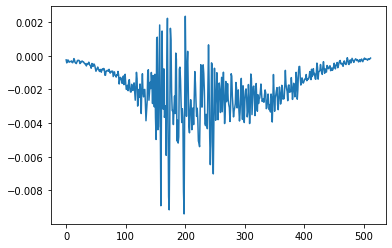

In [20]:
plt.plot(out_irfft)